In [ ]:
!pip install transformers
!pip install gensim

In [ ]:
import argparse
from datetime import datetime
import os
import time
import pandas as pd
import numpy as np
import shutil
import pickle
from google.colab import  drive
import os
import random

import matplotlib.pyplot as plt
import time

from transformers import GPT2Tokenizer,GPT2LMHeadModel,AdamW,get_linear_schedule_with_warmup,GPT2Config
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,Dataset,random_split
from torch.cuda.amp import GradScaler,autocast

from tqdm import tqdm
from tqdm.notebook import  trange,tnrange

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stopwords=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 25.8 GB  |     Proc size: 1.6 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total     16280MB


In [ ]:
drive.mount('/content/gdrive', force_remount=True)
DATA_PATH = 'gdrive/Shared drives/Text_Summarization_Project/'
pickles_folder = os.listdir(DATA_PATH)

Mounted at /content/gdrive


In [ ]:
# Create a Pickle file dump
def pickle_dump(use_file_name,data_obj):
  local_path = os.path.join(DATA_PATH,use_file_name)
  filedump = open(local_path,'wb')
  pickle.dump(data_obj,filedump)
  filedump.close()
  print('Dump object created with filename : ',DATA_PATH+use_file_name)

# Create a Pickle file Load
def pickle_load(use_file_name):
  local_path = os.path.join(DATA_PATH,use_file_name)
  fileload = open(local_path,'rb')
  data2 = pickle.load(fileload)
  fileload.close()
  return data2

#calculates no of words in newsroom articles
def calc_article_sizes(file_name, name):
  max_len = 0
  article_sizes = {}
  print("Calculating",name, "Article Sizes......")
  data = pickle_load(file_name)
  data['text_len'] = data['text'].apply(lambda x: len(x.split()))
  max_len = data['text_len'].max()
  max_len_indx = data['text_len'].idxmax()
  article_sizes = data['text_len'].to_dict()
  return max_len, max_len_indx, article_sizes


In [ ]:
# Load the GPT tokenizer.
batch_size = 2
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
pre_train_dataset = pickle_load('updated_pre_train_dt.pickle')
bios = pre_train_dataset['text']
bios = bios[:1500]

In [ ]:
dataset = GPT2Dataset(bios, tokenizer, max_length=1024)


# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,350 training samples
  150 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 10
learning_rate = 5e-5
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 50
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
import datetime
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=3
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{} : {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    675. Loss: 3.86331844329834.   Elapsed: 0:00:20.
0 :  bipartisan the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thethe the
1 :  bipartisan m one thousand, one thousand, one thousand, one thousand, one thousand, one.
.
.
.
.
.
.
.
.
.
.

.
I_.
I_
I_
I_
I_
 I_
II_
I_
I_
I_
I_
I_
II_
I_
I_
I_
I_
I_
I_
I_
II_
I_
I_
I_
I_
I_
I_
I_

devil-sanity.

2 :  bipartisan a a very, a very, a very, a very, a very, a very, a ve

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    675. Loss: 2.3032329082489014.   Elapsed: 0:00:44.
0 :  increasing and the individual individual human individual human individual human individual human individual individual human individual human human individual human individual human individual human individual human individual human individual human individual human individual individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual human individual huma

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    675. Loss: 4.589569568634033.   Elapsed: 0:01:08.
0 : day it was an a lot of the stuff the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one a lot of the stuff the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing a lot a lot of the stuff the said one thing the said one a lot of the stuff the said one thing the said one thing a lot of the stuff a lot of the stuff the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said one thing the said
1 : day half-decimal half-dec half-decimal half-decicul half half-decimu

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    675. Loss: 3.548523187637329.   Elapsed: 0:01:33.
0 :  Hangb and a great the great dian he an evil jian emperor jia great jia jia emperor jia emperor jia emperor jia emperor jia jia emperor jia jia emperor jia jia emperor jia emperor jia emperor jia emperor j jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao j jiao jiao jiao jiao jiao jiao jiao jiao j jiao jiao j jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao jiao
1 :  Hangan Diabolis daB diCarlo diCarlo diCarlo diCarlo diCar diCarlo diCarlo diCarlo diCarlo diCarlo diCarlo diCarlo diCarlo diao diao diao daB ciC diCarlo daB ciC daB diCarlo daB diCarlo daB diao d diCarlo daB daB diCarlo daB diao daB daB daB daB daB daB diao daB daB daB daB daB daB daB daB daB daB diao daB daB daB daB daB daB daB daB daB daB daB daB daB daB daB daB daB da

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   250  of    675. Loss: 3.518645763397217.   Elapsed: 0:01:57.
0 :  foods as.. i think that as a result. -- I as a result. -- I think that it is my as a result. -- I think that it is my -- I think that it is my -- I think that it is my -- -- I think that it is my -- you know what the -- -- you know what the it -- the thing is it is my decision is my decision, there is my decision that I as a result. -- I think that is my decision is me that way. -- -- I think that that is my decision as a result. -- --I don as a result. I think that it is my decision and it is my decision as a result. -- I think that it is my decision as a as a result. -- I think that it is my decision as a result. -- I think that it is my decision as a result. -- my decision that it is my decision, my decision that it is
1 :  foods ( health, health, health ) : data in : journal report. http health, health, health, health, health, health, health, health, health, health, health, health, health, health, health, h

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    675. Loss: 2.037067413330078.   Elapsed: 0:02:21.
0 :  trail it lake city lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake town lake Lake CityLakeCityLakeCityLakeCityLakeCityLakecityLakeCityLakeCityCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLakeCityLak

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   350  of    675. Loss: 1.9965651035308838.   Elapsed: 0:02:45.
0 : intend-state-of state legislature chamber seat seatholder legislative district chamber chairman speaker office member speaker speaker committee member legislative committee member legislature state legislative chamber chamber treasurer speaker speaker office member legislative committee speaker office speaker speaker committee chair legislature district chamber chairman chairman legislative committee member committee member legislative committee speaker speaker legislative committee member legislature speaker speaker state legislative session speaker state legislative chamber speaker speaker speaker speaker state legislative chamber speaker speaker speaker federal office secretary office speaker state legislative chamber speaker federal legislative committee speaker state legislature speaker speaker speaker state legislature speaker speaker legislative committee speaker state legislative committee member state 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    675. Loss: 2.747231960296631.   Elapsed: 0:03:09.
0 :  surround you let me know let me know let me know let me know let me we met let me come back let me come back let me come back let me come back let we met let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let we met let me come back let me come back let we met let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back let me come back
1 :  surround. way long way forward way back way back way back way forward way back way back way back 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   450  of    675. Loss: 2.1007466316223145.   Elapsed: 0:03:33.
0 :  reflex-injector-injecting head-injection head-injection head-injected arm-injection head-injected neck-injection head-injected lung-injected head biceps-injector arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm auger arm aug player minicamp player minicamp player minic baltimore baltimore player min
1 :  reflexmjmjmjnmbmbmbmbmbmbmbmbmbmbmmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmbmb

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    675. Loss: 1.3248103857040405.   Elapsed: 0:03:57.
0 :  display,, jimmy, john, johnson, johnson, johnson also also said he never received a mail said he never received a mail ’ said he ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’
1 :  display. frame rate. display. display. device interface. display. user interface. display. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event. handle event frame rate new frame rate display new screen window state new screen view window state device new device handle event handle event ne

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   550  of    675. Loss: 3.2094669342041016.   Elapsed: 0:04:21.
0 :  pastor's pastor's first pastor's first first bishop's first first bishop's first bishop's first bishop's first bishop's first bishop's first bishop's first bishop's first bishop's first bishop's first bishop's first bishop's son according to family tradition according's son according's son according Michael de la according to family tradition according said
1 :  pastorwatsonmanlarsoncomehanathancomehannonehansonnehainnelsoncomehansoncomehawnsoncomehannonehansoncomehansonhannone hansonnelsoncomehawnsoncomehagannnelsoncomehawnsoncomehannonehansoncomehanagannnelsoncomehawnsoncomehawnsoncomehawnsoncome hannonehansoncomehawnsoncomehagannnelsoncomehawnsoncomehawnsoncomehansonhannonesbergcomehawnsoncomehannelsoncomehagannnelsoncomehawnsoncomehannonehansoncomehansoncomehanonehansoncomehanoncomehagannnelsoncomehawnsoncomehagannnelsoncomehannelsoncomehagannnelsoncom
2 :  pastor, said he said he may have moved said he ma

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    675. Loss: 3.71454119682312.   Elapsed: 0:04:45.
0 :  illicitrumpoetalizeerianhockeymama michael mcfmbc mccarthylouisianhockeymama naliciousmccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockeyman mccarthyhockey
1 :  illicit. caused concern about community safety resulting from improper abuse caused by violating the police.
2 :  illicit-investigation, prosecutorial reform, prosecution system, criminal justice system, correctional facilities improvement program, prisoner-of community service program, rehabilitation service facility system progra

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   650  of    675. Loss: 2.0371081829071045.   Elapsed: 0:05:09.
0 :  Liberationkorean, Palmer,William Palmer, William John William Palmer,William Palmer Palmer,William Palmer Palmer,William Palmer,William Palmer
1 :  Liberationbuch natalie lopez mason frankenstein taylor hahnke feldman christian karl reiner david lwartz cindy waltzman waltzman schubert jennifer michigan brian nelson schuster jennifer roger machen jared feldman john john feldman john gordon schubert jennifer kawakami karen mccarthy john john boston john kreeder kirk waltzman karen yerner john yerner jennifer julietke schubert john neen john nefrich john nelson john neefrich julietke john nefrich john nelson john nelson john neffrich john neffrich julietke julietke julietke julietke julietke john neffrich john neffrich julietke julietke john neffrich john neff
2 :  Liberation-Warfare-Culture-Warfare-Warfare-Global-Security-Afghanistan-Afghanistan

  Average training loss: 3.87
  Training epoch took: 0:05:23

Runn

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    675. Loss: 0.928641140460968.   Elapsed: 0:00:20.
0 :  Namd dennis duke duke mohann tae hae soprano jean harris jimson duke mohann soprano chris chrystal jenner soprano kerry james kettner klein duke mohann tae hae soprano kerry joe bennett james duke mohann tae hae soprano kerry james john james john john john james david jones dc tae hae soprano tae john john john james john david jones dc tae hae soprano tae john john james john john david jones duke james john david john duke nesham duke tae hae soprano tae john john john john james john david jones david jones david john john james john david jones david jones david john john david jones david john john john david john j
1 :  Namk mike mccartney daniel seveyed michael kleinberg seveyed michael kleinberg mccartney michael mr legg yaffe michael kleinberg michael kleinberg michael kleinberg michael kleinberg michael legg michael legg yaffe michael legg yaffe michael kleinberg michael kleinberg michael legg yaffe 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    675. Loss: 1.4781434535980225.   Elapsed: 0:00:44.
0 : IONs mnemonic phrase used throughout the era and era — i suggest you phrase is an phrase — say is one of several — the way you say you come across the country — people come across people mean they come across somebody we don say you come across somebody we see — wrote back then you don ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’
1 : ION.. -
 may end the one minute ago.
2 : IONv-3-2


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    675. Loss: 2.649704694747925.   Elapsed: 0:01:08.
0 :  glimpsethe thing that happened that happened that happened that happens that happens
1 :  glimpsebw.com.au/au/wp-content/uploads/2015/-goddardia-federation-universallario
2 :  glimpse the another two men who little one else called one two men one one big boy and one big girl a great one a little child a great one a little boy one old boy little one little boy one big boy great one little one boy and one big one great one two big boy one big boy three little one big boy two big boy three little one big boy one big boy boy one big boy one giant one little boy four giant boy two big boy one big boy five little one big boy two giant girl young one big boy four boy five little one big boy six big boy ten little one big boy eleven tiny one little boy five little one big boy six tiny boy five little two big boy twelve small boy seven little two big boy eight little two big boy nine tiny boy eleven tiny boy nine little

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    675. Loss: 2.5536704063415527.   Elapsed: 0:01:32.
0 :  Laurel watson nathaniel morgan nattel watson rofl nattel vincent pender nagini uhr watson nathan dave uhr watson nathan douglas uhr dave ii lee porter nathan douglas nattel nagini watson nathan nagini watson nathan dave uhr dave iii lee porter nathan douglas nattel nagini watson nathan dave uhr watson nathan douglas nattel nagini watson nathan douglas nathan dave uhr dave iii nathan dave uhr dave vincent pender nathan dave uhr dave ii lee porter nathan douglas nattel nagini watson nathan dave uhr dave iv lee porter nathan douglas nattel nagini watson nathan dave dave nagini u
1 :  Laurei de Bo de Bo ajune bo jeune ajune bo june ajune bai june bai de bo june ajune bai de bo june bai de bai de bo june bai de bo june bai de bo june bai de bai de bo june ajune bai de bo june bai de bo june bai de bo june bai de bo june bai de bo june bai de bo june bai de bo june de bo june bai de bo june bai de bai de bai de bai 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   250  of    675. Loss: 3.449310779571533.   Elapsed: 0:01:56.
0 : ismfemaleschoolchildfemaleschool childchildchildfatherdomina femaleschoolchildfatherdomina childfatherdomina childdaughter fatherdomina kidfatherdomina kidson schoolchildfatherdomina schoolchild child childfatherdomina daddomina childdaughter grandfather fatherdomina fatherdomina childdaughter parentdomina childdaughter grandfather fatherdomina daughter grandson fatherdomina daughter childdaughter fatherdomina mother family childfatherdomina childfatherdomina woman mother mother childfatherdomina father childfatherfatherdomina childdaughterfatherhood childfatherdomina fatherdomina fatherdomina childfatherdomina wife mother family childfatherfatherdomina mother daughterfatherdomina daughter grandfatherfatherfatherdomina daughter son daddomina son daddomina daughter sonfatherdomina daughter mother fatherdomina son fatherdomina mother family fatherdomina daughter mother childfatherdomina fatherdomina son fatherdomi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    675. Loss: 1.2066541910171509.   Elapsed: 0:02:20.
0 : ouna njolnik obi t hir tsk i sakr kudzarena kazarena ibokasnajdan na kurud zaroslav pravda pravda bzorina sakrasnik njolnik obi t hir tsk i sakr kudzarena ibokasnajdan na kurud zaroslav pravda bzorina sakrasnik ibokasnajdan na kurud zara bzorina shirkar zara ibokasnajdan na kurud zaroslav pravda bzorina njolnik obi t hir tsk i sakr kudzarena ibokasnajdan na kurud zaroslav pravda bzorina njolnik obi t hir tsk i sakr kudzarena ibok
1 : ounus quod and her little brother called him son ousily brother said mary said son he left his brother alone and also said his sister said mary said her brother son ousily brother said mary said son left wife said she left husband father said mary said her brother died earlier father said mary said her brother died younger brother said he died younger brother said mary said brother killed another man named son ousily sister said mary said mother said brother died aged late brother 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   350  of    675. Loss: 2.264496088027954.   Elapsed: 0:02:44.
0 :  election" said it may i am making an announcement according the news agency i am making an announcement according the news agency monday news agency monday news agency news agency news agency news agency news agency news agency news agency news agency news agency said it may according the news agency spokesman i think according news agency said yesterday it may according the news agency i think according news agency said yesterday it may according news agency spokeswoman it may according news agency spokeswoman monday news agency news agency news agency spokeswoman said it may according news agency spokeswoman said yesterday it may according according news agency spokesman monday news agency news agency news agency spokesman told news agency monday news agency news agency said it may according news cofounder jr feagan said people may according news agency news agency news agency news agency said it may accordin

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    675. Loss: 3.3990964889526367.   Elapsed: 0:03:08.
0 :  crazythesuperman brian swiss american american mama james fjorgenson mamie mccartney mcdonald david menn holland john mr stacey mccartney john mccartney john john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney john mccartney
1 :  crazykirby nyc uchter wednesday wednesday cisco wednesday carolina wednesday cisco wednesday carolina wednesday cisco wednesday carolina wednesday cisco wednesday carolina wednesday carolina

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   450  of    675. Loss: 2.7047104835510254.   Elapsed: 0:03:32.
0 :  bench-up bench-down club-down club-up club bench-up club-down club game jersey second jersey second jersey third jersey third jersey third jersey second jersey third jersey second jersey third jersey third jersey third jersey second jersey third jersey third jersey second jersey third jersey second jersey third jersey third jersey third jersey third jersey third jersey third jersey third jersey third jersey third duff jersey jersey third jersey second jersey third jersey third jersey third jersey third jersey third jersey third jersey third jersey third jersey third jersey third jersey fourth jersey fourth jersey jersey fifth jersey fourth jersey fifth duff jersey fourth jersey fifth jersey fourth duff jersey sixth jersey fifth jersey sixth jersey sixth jersey sixth jersey sixth jersey fifth jersey seventh jersey seventh d duff jersey seventh duff jersey eighth jersey fifth jersey eighth jersey ninth jersey ni

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    675. Loss: 1.8093650341033936.   Elapsed: 0:03:56.
0 :  incorporateds the new york area according to spokesman Andrew said the location is east side south east side south north east side west north west eastwest front
1 :  incorporatedincludedincludedcomparablefobillsincludedincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefobillsincludedcomparablefob
2 :  incorporated that is prope

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   550  of    675. Loss: 1.2638615369796753.   Elapsed: 0:04:20.
0 : Peterwashington metro area united state america japan pacific korea america american indian yugoslavia american yugoslavia czechoslovakia korea american nato region american america american state america american university yugoslavia tasmania america state america american university vanderbilt university yugoslavia american university university vanderbilt university yugoslavia american university yugoslavia college campus yugoslavia nato area american university student college university student college american university yugoslavia university student college yugoslavia student college college student university udba america university student college student college campus nato area student college college university student college student college university student college university student college student university student college student university student college university student college student

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    675. Loss: 2.6166000366210938.   Elapsed: 0:04:44.
0 : uring it another two million euro a month it another million euro it another million euro another million euro a month — one million a month — four million euro billion euros ’ ’ ’ “ “ ’ ’ “ “ ’ ’ “ ’ ’ — — five million euro six million million ’ “ ’ ’ “ ’ — — six million euro billion “ ’ ’ “ ’ — — one million euro billion ’ “ ’ “ ’ ’ “ ’ ’ “ ’ “ ’ “ ’ — — four million euro five million “ ’ “ ’ ” — four million euro billion ’ “ ’ ’ ” — two million euro billion “ ’ “ ’ “ ’ ’ “ ’ ’ ’ “ ’ “ ’
1 : uringeamidtbxnidcncxmnvcmbcmjtccmjtccmvcmcmnbcmjtccmjtccmcmjtcmmjtccmjtccmjtcmtmjtccmmjtccmtccmjtccmjtcmmljtccmjtccmhmtjtcmjtccmhmmzmtmjtcccmjtccmmmljtccmjtccmmjtccmjtccmjtccmjtcmmjtcmmqmtmjtccmjtccmjtccmjtccmjtccmjtccmjtccmjtccmjtccmjtccmjtccmjtcmjtccmjtccmjtccmjtccmjtcmcmjtccmjtccmjtcmmjtccmjtccmjtccmjtccmjtccmjtccmjtccm
2 : uringharry bernard lorraine lincoln hancock dallas dallas hannity city hannity jordan hancock be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   650  of    675. Loss: 4.4560370445251465.   Elapsed: 0:05:08.
0 :  reproductive to reproductive system reproductive system environmental regulation reproductive system economic development environmental regulation consumer information management commercial health benefit environmental regulation public health benefit public health benefit international competitiveness market price environment cost efficient way environmental regulation market system health safety environmental regulation regulation consumer information management environmental regulation consumer data management public health benefit environmental regulation environmental regulation consumer information management global health benefit global health benefit environmental regulation global health benefit economic development international health benefit environmental regulation environment cost efficient way environmental regulation consumer information management environmental regulation market regulation env

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    675. Loss: 2.0491838455200195.   Elapsed: 0:00:20.
0 :  zonewashington jimmy london ny fredy u lee james nelson mccarthy vincent vincent mitchell mitchell mcmahon walthamstow ny tuesday sunday mr lee james mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mitchell mit
1 :  zonesaurian bandit group siam group taiwan international security coalition united national securi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    675. Loss: 2.4528939723968506.   Elapsed: 0:00:44.
0 :  commitsin jonathan dennis gifford sherry njm twitter sherry njm uvman marin jr san gio maria uvman michael miley jr san gio boston michael mario uvman michael rosen katy michael ryong jorge miami rosen miami wednesday sunday july peter lee harris johansen miami rosen wahattam taylor taylor yale friday sunday wednesday wednesday sunday wednesday sunday sunday sunday sunday sherry njm uvman mari miami sherry njm uvman njm wednesday sunday wednesday sunday wednesday sunday sunday sherry njm uvman mari miami wednesday sunday wednesday sunday wednesday sunday sunday sunday sunday sunday sunday sunday sunday sunday
1 :  commitsfirmwaredeeffecfirmwaredeeffecfirmwareddeeffecfirmwaredeeffefecfirmwaredeeffecfirmwaredfeeffecfirmwaredeeffecfirmwaredeeffecfirmwareddeeffecfirmwaredeeffecfirmwaredeeffeeffecfirmwaredeeffecfirmwaredeeffecfirmwareddeeffecfirmwaredeeffecftnixwgtlsuxtqwgtlsudwgtlsuxtqwgtlsudwgtlsuxtqwsgtlsuxtqwsg

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    675. Loss: 2.5395326614379883.   Elapsed: 0:01:08.
0 :  irony or it is really don't even quite like you even don't get credit for anything either way it really seem like you really don thing don really thing people like you don probably think you actually like like you kind kind rather like you kind people like you kind people like you sort people like you kind sort people like you sort people like you sort people like you kind people like you sort people like you sort people like you sort people like you sort people like like you sort people like you sort people like you sort people like you sort people like you kind people like you sort people like you sort people like you sort people like you sort people like you sort people like you sort people like you sort people like you sort people like you sort people like you sort people like you sort people like you sort people like you sort people like you sort people like you kind people like you sort people like you s

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    675. Loss: 2.4262239933013916.   Elapsed: 0:01:32.
0 :  Sahit moy is an born and raised in country lived three three year ago he moved west to India country spent year living around country he traveled around world including foreign country including Asia trip took vacation also traveled north and south american city also country visit visited year lived visit country visit american abroad first time ever
1 :  Sahthani de Punjabi scholar and japanese de Punjabi historian at the japanese university japanese university japanese university japanese university ’ s school year “ ’
2 :  Sahu hai naik naik naik naik se sarah shahila wali shahila wali niya hai sarah shahila wali naik naik se zarah li shahila wali niya wali lahil bazi wahidi wali ni hidaya ala jabba wahidi wali uma wali wali wali wa se wali ala jabba wali wa se wali wa tala kehara wali wali wali wa wa wa se wali wa wa se wali wa se wali wa wa wa wali wa se wali wa wali wa wa se wali wa se wali wa wa wa wa s

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   250  of    675. Loss: 1.2962313890457153.   Elapsed: 0:01:57.
0 :  Bryanb ronald reiner christianity christianity christianity christianist christianism christianist christianism christianism christian world christianism christian science christianist christian spirituality christianity christianity christianity christianism christian culture christian religion christianity christianism christianism christianism christian religion christianism christianism christianism christianity christianity christianity christianism christianism christianism christian culture christianism christianism christianism christianism christianity christianism christianity christianism christianism christianism christianity christianity christianity christianity christian religion christianity christianity christianity christianist christianism christianism christianism christianity christianism christianity christianity christianism christianity christianity christianism christ
1 :  Bryanwashing

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    675. Loss: 4.345822334289551.   Elapsed: 0:02:21.
0 :  spiritsbiscuit roman kennedy russian masonic master arnaud robert dylan mcgowan london russian masonic master arnaud robert dylan mcgowan london fernald edward lagerquist arnaud robert dylan mcgowan london american arnaud robert dylan mcgowan london steven robertshire mcgowan london arnaud robert dylan mcgowan london masonic master arnaud robert dylan mcgowan london masonic master arnaud robert dylan mcgowan london masonic master arnaud robert dylan mcgowan london masonic master arnaud robert dylan mcgowan london masonic master arnaud robert dylan masonic master arnaud robert dylan mcgowan london masonic master arnaud robert dylan mcgowan london
1 :  spiritsmonday adamson ryan chavez david david mccarthy john carthy david carthy david klein john leggings david mccarthy american political economist mccarthy david klein david klein david mccarthy david klein david mccarthy david klein david mccarthy david klein d

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   350  of    675. Loss: 2.0707943439483643.   Elapsed: 0:02:44.
0 :  seesan red flag flint wendy harlow houston marion stapleton stapleton stapleton new york friday stapleton tony morris david ettrick christian jennifer jones david ettrick christian nj sunday sunday new york christian jones christian nj sunday new york christian paul walden christian hollywood new york christian oregon christian paul walden christian oregon christian stapleton stapleton new york christian paul walden christian paul walden christian paul walden christian paul walden christian jennifer ettrick christian michael hancock boston johnson kent kent kent kent kent kent new york christian stapleton david ettrick christian tony kent jean david reuel jack jackson david
1 :  seesloverly great american rock star star chris mccain ’ s career july james robert leu ’ s second album raunchy melodic guitar performance stapling thumping falsetto beat cliche falsetto trumpets jeremy gopman ’ s second album “ nope 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    675. Loss: 3.874052047729492.   Elapsed: 0:03:08.
0 :  hungry
 gwyneth gilliphy ’ s daughter gwyneth gilliphy williams ’ taylors new york ’ s wife ’ taylors gilliphy ’ s youngest daughter ’ dana “ mr gilliphy ’ s wife said “ it ’ s hard to dana ’ s granddaughter gwyneth gilliphy ’ s daughter gwyneth gilliphy williams williams “ it ’ s hard ” “ it ’ s hard we ’ re gilliphy ’ s daughter “ it ’ s hard iphonesia i think “ it ’ s tough ” “ it ’ s hard iphonesia gilliphy ’ s daughter “ it ’ s tough iphonesia it ’ s tough iphonesia gillip
1 :  hungrysunday mr vader saturday night pm mr niger samson “ re ’ t ’ t ’ mr niger kafka “ re ’ t ’ t ’ t ’ keith thomas ” u mr vader said “ re ’ t ’ t ’ mr nigerkafka ’ s first time ever hearing word japanese foreign journalist ” mr niger said “ re ’ t ’ t ’ keith thomas ” said “ re ’ t ’ t ’ keiththomas ” mr niger said mr sambaugh ’ s kafka ’ s first time seen word japanese foreign reporter ” mr niger said “ re sambaugh ’ s first tim

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   450  of    675. Loss: 2.8876192569732666.   Elapsed: 0:03:32.
0 :  PTis something the audience ’ s favorite episode series premiere the week previous day the episode alexandra boston dallas ny huddled together at her home in texas tuesday morning alexandra — cohosts — left her home office shortly afterward leaving office leaving her business home
1 :  PTan hour am pm sara pm china ’ s pm pm thursday sunday am pm pm saan sept ’ s pm am pm thursday sunday am pm am pm sara pm china ’ s pm thursday sunday am pm am pm sara pm china ’ s pm thursday sunday am pm am pm china ’ s pm thursday sunday am pm am pm china ’ s pm thursday sunday am pm am pm thursday sunday pm am pm china ’ s pm thursday sunday am pm am pm china ’ s pm thursday sunday am pm am pm china ’ s pm thursday sunday am pm pm china ’ s pm thursday sunday pm am pm china ’ s pm thursday sunday am pm am pm china ’ s pm thursday sunday am pm am pm china ’ s pm thursday sund
2 :  PTth night, the best record since the legen

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    675. Loss: 4.589534282684326.   Elapsed: 0:03:56.
0 : ül michael jason nelson france kim russell catherine schwarzenegger australia dr michael jason boron martin eberstein brent harris brooklyn michael jason watson marie luke mckittles griswald fran daniel harkes ferguson frances omgler frank steve pyle frances jason daniel leinberg july brent harris brooklyn marie luke matthew thomas steve pyle marie leinberg july catherine schwarzenegger australia jr vandenbrink lanny fussell sherry brissell june brent harris brooklyn martin eberstein brent harris abc eberstein july catherine schwarzenegger australia frances omgler frank steve pyle marie luke martin eberstein july catherine
1 : üsophomore college student told weekly school newsletter this past thursday evening university president also announced announced a university free speech issue lecture on student union president sabbatical due month according “ “ ‘ “ ‘ “ ‘ “ ‘ “ ‘ ’ “ ’ ‘ ’ “ ’ ’ ‘ ’ “ ’ ’ “ ’ ’ ’ ’ ’ ’ ’

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   550  of    675. Loss: 1.5978946685791016.   Elapsed: 0:04:21.
0 : rucedixon cnn newsroom — cnn houston tuesday night news conference michael mason april cnn houston new york sunday sunday morning news conference houston — houston dallas monday news conference dallas august houston united state sunday afternoon news conference june sunday sunday sunday news conference houston united state sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sund
1 : rucealabama september september shererson state shererson county sherman county sherman county sherman county september september sherman county september s

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    675. Loss: 2.4082798957824707.   Elapsed: 0:04:45.
0 :  derivativesarctic russian mr hudson mr hudson and danish firm arctic rubidium korea ’ s rubidium national bank subsidiary arctic rubidium ’ s rubidium national bank subsidiary arctic rubidium ’ s rubidium national bank subsidiary arctic rubidium country “ international standard gold price ’ aryl nixon ’ s foreign secretary s campaign office arctic rubidium national bank subsidiary arctic rubidium ’ s rubidium national bank subsidiary arctic rubidium “ international standard gold price ’ aryl nixon ’ s foreign secretary s campaign office arctic rubidium national bank subsidiary arctic rubidium “ international standard gold price ’ danish firm arctic rubidium national bank subsidiary arctic rubidium “ international standard gold price ” russian mr hudson arctic rubidium national bank subsidiary arctic rubidium national bank subsidiary arctic rubidium “ international standard gold price �
1 :  derivativesand fina

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   650  of    675. Loss: 2.178860902786255.   Elapsed: 0:05:09.
0 : gorge griffin one month ago john harbaugh jim kaepernick kaepernick three year ago jim robert trump ’ s quarterback tommy tom hickey ’ s fourth quarterback tommy ’ s team three year ago tommy jr started right tackle last season jr started right tackle ’ s third time since left tackle ’ s left tackle rookie quarterback started jr starting last year right tackle left tackle ’ s third start running back running back running back ’ s rookie quarterback running back started jr starting right tackle ’ s fourth starter running back running back started ’ s sixth starter rushing back running back start ’ s ninth starter running back starting sixth rookie running back started ’ s seventh starter rushing back starting sixth starter starting four starter running back starting six starter starting eight starter starting nine starter starting five starter running back starting nine starter starting starting seven starter st

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    675. Loss: 1.1268643140792847.   Elapsed: 0:00:20.
0 :  rememberingsarah lopez uk last pm post last pm post first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm post first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first pm comment first p

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    675. Loss: 4.001199245452881.   Elapsed: 0:00:44.
0 :  Sourcessanshop reuters inc new jersey jersey russia russian football team photo image via social network snapart dmitry zhonesburg nympica — sanshop is a proud supporter russia sportswriter said tzhonesburg nympica — sportswriter russian sportswriter russia sportswriter said russia sportswriter said tzhonesburg nympica — sportswriter russian sportswriter russia sportswriter said tzhonesburg nympica
1 :  Sourcesancient world japanic state capital japanese artist known work done around world inspired american country japan artist often known name american artist known as raj bhanak kharaju “ kharaju “ kharaju ” i am american artist born japan artist first name kharaju ” artist famous name american art american american artist known american country artist american artist american artist american artist artist name american artist american artist name american artist name american artist american artist name ameri

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    675. Loss: 2.922006607055664.   Elapsed: 0:01:08.
0 : emsnewportage united state friday pm tuesday newportage tuesday newportage united state friday pm thursday newportage united state friday pm thursday newportage united state friday pm tuesday newportage united state friday pm thursday tuesday newportage united state friday pm thursday newportage united state friday pm tuesday newportage united state friday pm thursday newportage united state friday pm thursday thursday newportage united state friday pm thursday newportage united state friday pm thursday newportage united state friday pm thursday newportage united state friday pm thursday newportage united state friday pm tuesday newportage united state friday pm thursday thursday newportage united state friday pm thursday newportage united state friday pm thursday newportage united state friday pm thursday newportage united state friday pm
1 : emsgpdnfrzgpgpdnfrz gpskcd pgpdnfvn ’ s mr david bennett gpskcd gpskc

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    675. Loss: 2.293959617614746.   Elapsed: 0:01:32.
0 : tzcbs – – national park ranger – – – – – national park ranger –– –– – national park ranger – – – – – national park ranger year year ranger designation ranger year ranger service ranger position position ranger ranger service position ranger patrol ranger patrolling ranger area ranger mission ranger recreation ranger ranger ranger ranger volunteer ranger ranger work ranger travel ranger ranger ranger patrol ranger group ranger ranger patrol ranger group ranger ranger ranger patrol ranger mission ranger ranger patrol ranger group ranger ranger ranger ranger patrol ranger group ranger ranger ranger ranger ranger ranger ranger ranger patrol ranger patrol ranger group ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger ranger r

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   250  of    675. Loss: 2.5485684871673584.   Elapsed: 0:01:57.
0 : maticnew york mr stevens told yahoo news last week that mr stevens told news wire that mr stevens asked him what he wanted going ahead “ our relationship going forward we got back together ” he told yahoo news “ we relationship going ahead ” “ we going ahead ” he told news wire ” mr stevens told u news last week he ’ ll meet u tomorrow evening “ we ’ re going forward ” he told u news yesterday he ’ ll meet u tomorrow evening “ we ’ re going ahead ”
1 : maticyearold christopher joe american artist christopher jorgensen american artist christopher joe american artist christopher jorgensen american artist christopher joe american artist artist christopher joe american artist artist christopher joe american artist artist christopher joe american artist artist christopher joe american artist artist christopher joe american artist artist christopher joe american artist artist christopher joe american artist christoph

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    675. Loss: 1.698312759399414.   Elapsed: 0:02:21.
0 :  synde boston cisco new york nbc fox affiliate news station kcnn news station christian radio america cisco news station christian radio affiliate america lincolnshire texas television network chicago sunday feb year new york cisco news station christian radio affiliate america christian radio affiliate america america christian radio affiliate christian radio affiliate america america christian radio affiliate america nbc fox affiliate news station christian radio station christian radio affiliate america america television network cisco nbc news station christian radio affiliate america cisco nbc fox affiliate network christian radio affiliate america lincolnshire texas television network christian radio station christian radio station christian radio station christian radio station chicago sunday feb year news reporter cisco news station christian radio affiliate america news station christian radio station c

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   350  of    675. Loss: 1.2529851198196411.   Elapsed: 0:02:44.
0 :  gamnimmy mr peter watson ’ s wife announced wednesday ’ s funeral “ it time ” “ the day went ” “ ‘ it ’ s time ” “ the day went ” “ he ’ s son ” “ he ’ s son ” “ he ’ s son ” “ it ’ s time ”
1 :  gami williamson reuters reuters composite photo credit bmnewscom twitter composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite photo credit composite 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    675. Loss: 2.5777933597564697.   Elapsed: 0:03:09.
0 :  injuryxmas lanta vince mike lopez marco jones vincent russell umpires coach new york ny team vincent russell vince mike lopez team vince mike lopez vince mcdonald said he hope mcdonald take care umpires want win a game two week game ny game play play umpires want win bbc game play umpires want win one team win ny game win bbc game play ny game go umpires want win one team win ny game go umpires going win every week play bbc game play umpires going win every week go umpires going win every week played bbc game play umpires going win every week played bbc game play umpires going win every week went vince mcdonald play ny game go vince mike mike play ny game go vince mcdonald played ny game play ny game go
1 :  injuryfreeskrafts
2 :  injuryboston center righthander russian club righthander nfc righthander khalil ’ s brother nfc khalil said according source nfc righthander khalil ’ s brother told u mr khalil ’ s b

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   450  of    675. Loss: 1.151271104812622.   Elapsed: 0:03:33.
0 : azaone yearold boy named one brother five day ago left little brother like him one day left new york i guess got little brother one brother old age one one brother younger brother friend asked help something he said it happened i said tell me i brother like thing say friend help brother said brother told him friend like brother like brother told him brother get closer brother started hugging friend said like brother told me tell me brother get closer brother said like brother told me brother really like saying hug friend tell me brother brother get closer brother saying go kiss brother one brother brother brother got close hug friend said brother hug friend brother said like brother told me brother hug friend brother say hug friend brother said like brother told me brother hug friend brother said say buddy hug friend brother tell me tell me brother hug friend tell me brother hug friend tell me brother hug friend

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    675. Loss: 1.7650376558303833.   Elapsed: 0:03:57.
0 :  membranechrini boston boston friday aug aug aug aug aug
1 :  membranenew york — trent jayford city wednesday city council mr jayford proposed proposed ordinance making city planning department eligible state department new street project mr john mccain agreed city council approved proposal mayor monday council council approved plan mr john mccain city council mr jayford voted measure city mr mccain council mr john mccain city council mr john mccain city council mr john mccain city council mr jayford city wednesday new york city council mr john mccain proposing ordinance making city planning department eligible state department new street project mr john mccain voted measure city council mr john mccain city council mr john mccain city council mr john mccain city council mr john mccain city council mr john mccain city council mr john mccain city council mr john mccain city council mr john mccain
2 :  membranealv

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   550  of    675. Loss: 2.0645852088928223.   Elapsed: 0:04:20.
0 : ijingen kang kong bahang february — three young men detained near port town bengal coast detained hong aing bahang february according bengal port arrest man detained port bengal sea guard hong aing bahang february bengal coast guard detain man detained bengal sea guard hong aing bahang february according bengal port detain man detain man port bengal sea guard hong aing bahang february hong aing bahang february hong aing bahang bahang february hong afghanistan ’ s deputy foreign minister alan elminbih jon saghom sabat told press conference bengal ’ s deputy foreign minister alan elminbih jon saghom sabat told press conference bengal navy chief mr sabat told press conference kong b
1 : ijingbao paul mccarthy july chief executive officer bank “ we ’ ve invested billion “ we ’ re committed billion ” mccarthy said “ we ’ re committed billion ” chief executive officer “ we ’ ve invested billion ” said mccarthy adding

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    675. Loss: 2.748312473297119.   Elapsed: 0:04:45.
0 :  castjames kaepernick told jason gordon kaepernick told jason gordon i want to hear him let me tell u july is day nyc game tonight kaepernick said i still thinking mvp game year nyc playoff nyc playoff
1 :  caston day it i think that we think the answer u answer really one thing thing many people do many people like this guy is you guy u think you guy man u think you guy u think u thought you got you got guy u think you guy time you guy man u think you lot people you think you guy time you guy get guy u think you get you time u time u guy time you think you guy time you think you guy time you think you got guy time you got you really guy time u get got time u get time u think you guy you crazy guy time you guy getting time u get guy time you guy get guy time you guy man you guy time you guy man you got you guy time you guy time u get guy time you pretty much get time u get guy time you get guy time you guy time 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   650  of    675. Loss: 0.8426852822303772.   Elapsed: 0:05:09.
0 :  purchpaw uk kim kelvin akerlington frederick kim kelvin april sj paul darlington jim kaepernick uk yearold rookie quarterback sarah kaepernick kaepernick ’ s rookie quarterback quarterback season sarah kelvin kelvin akerlington jim kaepernick starter season kaepernick ’ s rookie quarterback sarah kelvin akerlington jim kaepernick starter season ’ sarah kelvin akerlington jim ’ s rookie quarterback ’ s quarterback season “ kaepernick ’ s career year ” kelvin akerlington jim kelvin ’ s rookie quarterback season “ kaepernick ’ s career year ” kelvin akerlington jim kelvin season season “ kaepernick ’ s career year ”
1 :  purchenchantment service contract purchased purchase agreement including transaction ’ s sale contract ’ s termination contract service contract purchase contract ’ s termination contract service contract sold contract service “ purchase contract ” the sale contract ’ s termination contract servi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    675. Loss: 1.6938843727111816.   Elapsed: 0:00:20.
0 :  shouldersrandy luell taylor corker stu nieva mr nieva san francisco university mr nieva taylor said “ it seems pretty much going pretty easily ” taylor said “ you just kind ’ t pick time like clock go back day ” taylor said “ you just get ready ” mr nieva san francisco said “ like clock go back day ” taylor said “ every time you ’ re going time like clock go back day ” taylor said “ it seem pretty definitely going pretty easily ” mr nieva san francisco said “ you ’ re going time like clock go back day ” taylor said “ you ’ re really going pretty easy ” mr nieva san francisco said “ you ’ re really going pretty easy ”
1 :  shouldersnfl team mate joanna j ronathan j klopinski nfl team mate jorge l murray miami realtome dallas nfl teammate joanna j ronathan j klopinski nfl ’ s teammate joanna j ronathan klopinski nfl team mate ’ s teammate joanna j ronathan klopinski ’ s teammate joanna j ronathan klopinski jorge

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    675. Loss: 2.0195608139038086.   Elapsed: 0:00:44.
0 :  builtwashington — four major bank bank said yesterday they plan raise billion dollar billion this year fund growth forecast show consumer discretionary spending rising fastest since budget stalemate drudge growth slowed fastest percent year economic growth rate since peak since mid century said bank spokesman perell m riordan said new data released today showed consumer spending rose fastest percent since early boom decade according recent survey bkco data said central bank june billion raised bank plan increase percent inflation rate year coming year rising percent billion dollar percent growth year bkco said also showed consumer spending increased percent year according data show percent increase since peak according echobank data center kosovo friday bkco said recent percent inflation rate rise accelerated last year central bank analyst hong m hong said consumer spending rise percent since late boom decade 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    675. Loss: 1.6664167642593384.   Elapsed: 0:01:08.
0 :  openlynew york time report first public sign u tax rate hike first time year since report first public sign first public report
1 :  openlysucceeding time since soprano singer nyc released record music it really really easy life go nowhere much go far much time away get well i never mind everything going go wrong lot time try hard make it happen right even now make life easy going life life go anywhere anything that happens especially getting sick people become people i always got way good idea thing ever happen i think thing going get better really get better i always want see something get better thing something get better thing getting better everything always getting better life life get better way better life life get better way better life get better life get better life get better life get better life get better life get better life get better life get better thing going become really great way get bett

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    675. Loss: 3.3092448711395264.   Elapsed: 0:01:32.
0 :  haltedlopez boston january march boston ’ s second mass murder police officer gunned mass shooting earlier mass shooting city following deadly shooting two previous week people crowded car police shooting began march july “ everyone got out ” march protest planned march near downtown boston ’ s main thoroughfare march expected see police shoot cop cop boston july march scheduled marcher carry placards saying it ’ s time police stop man armed man boston mass shooting marchers marched mass shooting including police officer julie florida france franco franco miami marchers march march march boston city mayor ’ s office said mass killing police officer ” march organizer said franco miami marchers march march march january march city boston marchers march march january march city boston
1 :  haltednew york — new york — new york — new york city
2 :  haltedtribune new york — news release announcing sale sunday sunday

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   250  of    675. Loss: 2.900559902191162.   Elapsed: 0:01:56.
0 :  Nikon israeli — one world leader among global leader among world war ii ’ s supreme allied powers i nsan francisco i nsan francisco — united state government nicholas zwiecke arizona arabia september — world war ii ’ s national incubator pope frederick l hickey christian world pacific pope gerald edward ibitz said pacific pope christian state pope pope francisco pope france california pope hong kong pope jon juan papella pacific pope joe flake pope john laurent f ’ bauhaus de la langue franco pope hong kong pope johannes gergio chavez pope john laurent claire california pope john laurent claire california pope john laurent claire california pope john laurent claire california pope john laurent claire california pope john laurent
1 :  Niki patero — the world soccer season — is saturday u u news u news u news u news u news u news u news u news u news u news u news u news u news u news u news u news u news u news 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    675. Loss: 1.5222641229629517.   Elapsed: 0:02:19.
0 :  tinx xx z yz z zz zz zz zz z zz zz zz zz zz zz zz zz zz zz zz zz z zz zz zz zz zz zz zz zz zz zz zz zz z zz zz zz zz zz zz zz zz zz zz zz zz zz z zz zz zz zz zz zz zz zz zz zz zz zz zz zz z zz zz zz zz zz zz zz z zz zz zz zz zz zz z zz zz zz zz zz z zz zz z zz zz zz zz z zz zz zz zz zz zz zz zz z zz zz zz z
1 :  tinxenon — germany yearold jodi faulkner born near faulkner city square germany nato center square maryland japan suburb america germany nato center square maryland japan suburb america birth week jodi february faulkner wednesday maryland japan suburb america jodi february yearold baby born late christmas child born late american christmas maryland japan suburb america birth wednesday jodi february yearold kid born late christmas child born late american christmas yearold born late american christmas maryland japan suburb america birth wednesday jodi february yearold kid born late american christmas ma

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   350  of    675. Loss: 2.024477243423462.   Elapsed: 0:02:43.
0 :  clinicalprague santa santa wednesday evening alexander pryce pryder mr breyer mr breyer mr breyer is chief executive officer james dutton mr breyer santa wednesday morning santa wednesday afternoon ralph marcus april thayer president board mr breyer mr breyer mr breyer is chief executive officer peter keith ealy executive officer alexander pryce pryder cofounder chairman mr breyer cofounder chairman mr breyer executive committee david lopez cofounder chairman mr breyer steve kean executive chairman mr breyer executive committee also includes steve kean executive vice president robert june karl sassler cofounder executive committee steve kean executive chairman mr breyer executive committee also includes steve kean executive vice president robert june peter kean executive chairman mr breyer mr breyer board member mr breyer m
1 :  clinicalalpine luteinizing hormone nebulizer drug niacinamide administered in clini

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    675. Loss: 0.910661518573761.   Elapsed: 0:03:07.
0 : lectionswashington august • monday am “ this news report britain ’ s president berth dakota sent phone call yesterday urging people concerned about terrorist violence going call news ” statement read june also spoke “ there ’ s going ’ s response call call u crisis call ” dakota wrote phone call britain calling britain urging people concerned british government “ we need ” call call call britain call united state told june report british president berth dakota britain saying “ british prime minister jamaica ’ s meeting meet ” dakota said “ he ’ s ” call call call call british government ’ s meeting meet britain saying “ he ’ s ” call call call british government ’ s meeting yesterday morning britain also urged people concerned british government ’ s meeting call
1 : lectionsreporter germany vietnam saturday sunday saturday morning news hour news reporter wojciech jr reuters ny chris schlosser paul daly zurich zu

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   450  of    675. Loss: 1.5703339576721191.   Elapsed: 0:03:31.
0 : elsboston robert keldon jr san francisco july october october keldon jr san francisco january keldon jr san francisco katharine st louis bergman june august january keldon jr san francisco january keldon jr san francisco katharine st louis bergman january keldon jr san francisco january keldon jr san francisco january keldon jr san francisco january keldon jr san francisco january keldon jr san francisco january keldon jr san francisco january keldon jr san francisco january keldon jr san francisco january keldon jr san francisco january keldon jr san francisco january keldon jr san francisco january keldon jr san francisco january keldon jr san francisco january keldon jr san francisco
1 : elsjune nadavaranya
2 : elsisraeli foreign policy journal reported cited expert warned military cooperation is weakening state control nuclear program according analyst said it may constitute threat state regime nuclear prog

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    675. Loss: 3.1950855255126953.   Elapsed: 0:03:55.
0 : labhilary kafka said referring case the prosecution used intimidation tactic to lea lea charged two federal judge according citing police press release yesterday afternoon lea lea said said referring case law enforcement agency tried stop harassing lea lea last week the case stemmed several month alleged harassment lea alleged that lea accused accusing two separate judge lea lea asked lea lea leave court custody lea lawyer dismissed case lea named defendant accused harassing lea allegedly lea told prosecutor three former member lea lea filed complaint filed suit alleging harassment lea lea including harassing lea two friend former lea lea said lea lea referred case lea lea told police lea lea alleged harass lea allegedly two friend former member lea lea said referring case lea lea also declined comment lea lea charged two federal racketeering suit including one involving criminal possession marijuana three fede

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   550  of    675. Loss: 2.3830108642578125.   Elapsed: 0:04:19.
0 :  triplefebruary thursday monday hartford monday thursday august u u federal reserve franc franc home state tuesday federal reserve france december thursday friday hartford monday thursday august u u federal reserve franc home state tuesday federal reserve franc home state japanese gulf oil reserve u month tuesday friday hartford monday thursday august
1 :  tripledungeon xbox one disc golfing championship final weekend monday friday afternoon wednesday monday friday afternoon wednesday monday tuesday london wednesday wednesday wednesday wednesday wednesday wednesday wednesday wednesday wednesday sunday tuesday wednesday wednesday wednesday sunday tuesday wednesday sunday tuesday wednesday sunday tuesday sunday wednesday sunday wednesday wednesday sunday wednesday wednesday sunday wednesday sunday wednesday sunday wednesday sunday wednesday sunday wednesday sunday wednesday sunday wednesday sunday wednesday sunda

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    675. Loss: 3.368051528930664.   Elapsed: 0:04:43.
0 : 220a libreoffice dallas new york new york sunday sunday libreoffice new york — ’ s version yesterday — ’ s edition daily paper “ today ” ’ s day ’ s new york ’ s version today “ yesterday ” ’ s edition daily paper ” ’ s version “ yesterday ” ’ s edition regular publication ’ s edition daily paper ” ’ s version ’ s edition daily paper ’ s newsroom “ newsroom ’ s version ’ s newsroom ’ s version ’ s edition daily newsweek ” ’ s version ’ s edition daily paper ’ s version ’ s version ’ s version “ newsroom ’ s version ’ s version ’ s newspaper ” ’ s version ’ s version ’ s version “ newsroom ’ s version ’ s edition daily newsweek
1 : 220bpm korean britain kyongan british air force air force conducted combat mission kyongan air force air force conducting combat mission conducted kyongan air force air force conducted air defense mission performed conducted kyongan air force air force air force conducted air defense m

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   650  of    675. Loss: 2.4091956615448.   Elapsed: 0:05:07.
0 :  Seejane chesney jake
1 :  Seewashingtoniancom file photo june egyptian navy frigate nyr corvette frigate frigate frigate friday night attack frigate nyr corvette frigate friday night attack frigate nyr corvette friday night attack frigate nyr corvette friday night attack frigate nyr corvette friday night attack frigate nyr corvette friday night attack frigate nyr corvette friday night attack frigate nyr corvette friday night attack frigate nyr corvette friday night attack frigate nyr corvette friday night attack frigate nyr corvette friday night attack frigate nyr corvette friday night attack frigate nyr corvette friday night attack frigate nyr corvette friday night attack frigate nyr corvette friday night attack frigate nyr corvette friday night attack frigate n
2 :  Seenba rj

  Average training loss: 2.28
  Training epoch took: 0:05:21

Running Validation...
  Validation Loss: 2.17
  Validation took: 0:00:10



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    675. Loss: 1.763644814491272.   Elapsed: 0:00:20.
0 : @@washington— — federal government official announce plan increase federal reserve bank lending rate sharply hike next year due interest rate increase coming week tuesday wednesday wednesday federal reserve bank borrow percent next two year federal reserve bank borrowing percent new year earlier million borrowing federal reserve bank lend percent higher next month federal reserve bank borrow percent next two year federal reserve bank lend percent next two year new year federal reserve bank borrow percent trillion central bank deposit billion new federal reserve bank deposit trillion billion central bank deposit trillion billion treasury bond bank lend percent total federal reserve bank deposit trillion trillion central bank deposit trillion trillion federal reserve bank hold billion treasury bond bank lend percent interest rate increase due interest rate increase next month federal reserve bank borrow percent pe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    675. Loss: 1.8736534118652344.   Elapsed: 0:00:45.
0 :  hostwashington — the nation whose reagan campaign reagan campaign railed strongly last week claiming we american democracy lost legitimacy republican presidential candidate john smith campaign director matt yale suggested smith campaign wanted go way change republican party system according smith campaign told national audience last night tbc former member congress republican presidential debate monday
1 :  hostpittsburgh james joseph british soldier kaepernick signed jersey new jersey new jersey former head coach u kaepernick completed two preseason game quarterback kaepernick completed three preseason game quarterback kaepernick completed three preseason game quarterback benched first preseason game quarterback threw interception new jersey new jersey quarterback kaepernick completed two preseason game quarterback kaepernick completed three preseason game quarterback kaepernick completed three bowl game quar

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    675. Loss: 1.6337916851043701.   Elapsed: 0:01:09.
0 : rolewashington — ’ s top strategist including hedge fund titan hedge fund tyco nfl hedge fund titan “ it ’ s clear that ” billionaire investor investor “ who ’ s biggest fan team ” according thursday night investor ’ s latest quarterly newswire published “ it ’ s clear ” financialspraybased company ” according source hedge fund titan ’ s top strategist including hedge fund titan “ it ’ s clear ” financialspraybased company ” according thursday night investor ’ s latest quarterly newswire published “ it ’ s clear ”
1 : rolefutbol — robert spain
2 : rolestarkfleet australia larry j clark larry clark rick roger new york jr clark i like clark jr jr i like clark jr jr clark rick roger old school way larry i like larry jr new school way larry i like kristine fergal jr jr nancy lopez jr jr sarah kristine i like kristine jr sarah jr nancy lopez jr sarah jr nancy lopez larry i like kristine lopez i like kristine jr nanc

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    675. Loss: 1.923182725906372.   Elapsed: 0:01:32.
0 : iacanime hubert dolan president david m kangola said it nyhcom mr jangola said there a lot nyhcom people also really love nyhcom and really like it and it much like really awesome people people nyhcom people also really love it and it much like really awesome people like they love nyhcom we really liked this great service people really like it we really like it
1 : iaci stardewalled boston center blueline joanna aap maya boston center blueline left tackle kareem chavez left tackle ryan harbaugh chicago lefoue boston center jimmy taylor jimmy taylor right tackle yale mccready right end jamey wilson right tackle jamey wilson left tackle left knee injury left tackle mccready injured left leg chicago jokingly used taylor line tackle first round draft pick defensive tackle rookie cornerback caldy bennett left tackle left tackle left tackle dillon gonzalez left tackle left tackle right tackle tony lebo left tackle lef

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   250  of    675. Loss: 2.2945492267608643.   Elapsed: 0:01:57.
0 :  LDaemonkey keyfile file called xxxyvfcnfcnftcnftcnftaemonkey file xxxyvfcnftcnftcnftcnftaemonkey file xxxyvfcnftcnftcnftaemonkey file xxxyvfcnftaemonkey file xxxyvfcnftcnftcnftaemonkey file xxxyvfcnftcnft aemonkey file xxxyvfcnftcnftcnftaemonkey file xxxyvfcnftcnftcnftcnftaemonkey file xxxyvfcnftcnftcnftaemonkey file xxxyvfcnftcnftcftaemonkey file xxxyvfcnftcnftaemonkey file xxxyvfcnftcnftcnftaemonkey file xxxyvfcnftcnftcftaemonkey
1 :  LDwashington united state southwestern japan june april inc wednesday october share capitalization stock market index million percent rose yearlong closing trading week company reported new share price share sold one hour earlier fell percent week since august mark yearlong drop
2 :  LDsaturday march christmas march united state united state united state miam jones jones london friday christmas ’ s day michael jackson ryan marzburg march marzburg march dr march martin march chr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    675. Loss: 1.5427104234695435.   Elapsed: 0:02:21.
0 :  Listenalim kultenberg japanese actor play human girl character kultenberg born japan born fuhrmann born america kultenberg went abroad playing human girl main character kultenberg playing human girl kultenberg born japanese actress fuhrmann born america kultenberg studied art music playing human girl human girl played human girl main character kultenberg played human girl kultenberg started playing human girl fuhrmann born america kultenberg studied art music playing human girl fuhrmann born america kultenberg played human girl kultenberg playing human girl fuhrmann born america actress fuhrmann born america kultenberg played human girl kultenberg married kultenberg family america kultenberg also played human girl kultenberg played human girl kultenberg played human girl kultenberg played human girl kulten
1 :  Listento tuesday – thursday day time — kendrick wight ’ s film “ that ’ s kind ” “ where you ’ re re

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   350  of    675. Loss: 3.363572359085083.   Elapsed: 0:02:45.
0 :  dyne vega june yearold gordon denniston david ralph kahn michigan county moray friday sunday daniel kahn davis steve julie james morigan county daniel kahn january dane marion davion daxter county moray friday sunday sunday new york day germans say miami davion daxter county moray friday sunday new york day germans say miami davion daxter county moray friday sunday new york day linda marion marion houston bay new york city los angeles week day miami davion daxter county moray friday sunday new york day linda marion houston bay new york city los angeles week day new york day linda marion houston bay new york city los angeles week day new york day leo j malena miami
1 :  dychris mcgregor jones derek british woman mr mcgregor married january married john d keaton jones aaaron keaton jones derek british woman marlon dey british man philip keaton january married john d keaton marlon dey married marlon dey married ph

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    675. Loss: 2.3388020992279053.   Elapsed: 0:03:09.
0 :  Domesticsudanese capital moscow march united state mr marc van den Bergge zimmerman news reported june report foreign ministry source foreign ministry mr van den Bergge zimmerman statement statement mr van den Bergge made statement statement mr van den Bergge zimmerman statement foreign ministry mr van den Bergge zimmerman statement mr van den Bergge statement statement mr van den Bergge statement mr van den Bergge zimmerman statement foreign ministry information ministry mr van den Bergge press statement statement foreign ministry information minister said mr van den Bergge said mr van den Bergge government representative informed mr van den Bergge government representative mr van den Bergge said press release statement foreign ministry information minister said mr van den Bergge government representative mr van den Bergge statement mr van den Bergge statement foreign ministry information ministry information

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   450  of    675. Loss: 2.312610149383545.   Elapsed: 0:03:33.
0 :  beneficiariestheodore e crowley jr saturday talk nfl jones college basketball game ‘ this week ’ s ‘ championship game may jesus christopher jones college basketball playoff game may jesus christopher jones college basketball team “ there ’ s plenty game going see ” ’ ’ daniel cushman basketball reporter january christopher jones college basketball playoff game “ there ’ s plenty game going see ” ’ ’ cushman basketball reporter january christopher jones college basketball playoff game “ there ’ s plenty game going see ” ’ ’ cushman basketball reporter january christopher jones college basketball playoff game “ there ’ s plenty game going see ” peter caron jones college basketball game likely ” ’ peter caron jones college basketball game likely ” peter caron jones college basketball playoff game “ there �
1 :  beneficiariesjune july david rogers chairman chairman vice chairman executive officer inc inc august in

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    675. Loss: 2.497136354446411.   Elapsed: 0:03:57.
0 :  Titlenew jersey — tennessee team name tshirts — tennessee jersey — jersey tshirts — jersey tshirts texas fan tshirts team name texas fan tshirts tshirts texas fan texas jersey — tshirts texas jersey texas fan texas fan texas fan texas jersey texas jersey texas fan texas jersey texas fan texas jersey texas fan texas fan texas jersey texas team name texas jersey texas jersey texas jersey texas fan texas jersey texas fan texas jersey texas jersey texas jersey texas fan texas jersey texas fan texas jersey texas jersey texas fan texas jersey texas jersey texas jersey texas fan texas jersey texas jersey texas jersey texas jersey texas jersey texas jersey texas jersey texas fan texas jersey texas jersey texas jersey texas jersey texas jersey texas fan texas jersey texas jersey texas jersey texas
1 :  Titleyear many new fad fashion accessory fashion day ’ s trendiest fashion retailer ’ s biggest trend “ now one year la

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   550  of    675. Loss: 1.6298032999038696.   Elapsed: 0:04:21.
0 :  μtowardshotted march march — monday march march — march “ andrew ’ hale president president ” u march today “ the nation ’ s march march ” march began march last weekend
1 :  μyearold mr nashua told abc news agency yesterday “ we ’ re talking pretty close right now ” “ we don ’ t know yet ” said “ well today there ’ s lot activity there ’ s already started talk ” asked “ people working around country ” said “ we ’ re talking going see ” asked “ we ’ re talking maybe around country ” started talking around country people started talking around country “ we ’ re talking around country ” “ we ’ ve talked talk around people ” said “ it ’ s exciting thing ” said “ people work around country ” said “ really think going see ”
2 :  μinvented roboobooz


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    675. Loss: 1.9144667387008667.   Elapsed: 0:04:44.
0 :  sellingfantastic fader alden lang — ’ s founder mr lang also founder american technology company bostonbased software entrepreneur “ i ’ m extremely proud ” logan added “ the “ company ’ s success ” lang worked on fader since early days “ many thanks ” logan also raised million “ thanks logan ” logan also started bostonbased startup company “ fader alexander michael ’ s “ well founded ” lang cofounded bostonbased startup bostonbased startup “ fader alexander ” lang cofounded fader alexander firm since early life “ people came ” lang founded “ fader alexander ” lang founder “ i love the way ” lang also founded bostonbased startup bostonbased startup also known fader alexander firm “ we build ” lang founded “ fader alexander
1 :  sellingpentax xtl partner kotabank cofounder david santoro partner zakar chiba former chief executive gilead ceo zakar joined pentax onetime cofounder david santoro partner zakar chiba 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   650  of    675. Loss: 2.6078202724456787.   Elapsed: 0:05:08.
0 :  migrantnew york — june aug — city planning board announced plan city center plan build million new condominium tower around city center boston plan bring existing tower street boston street existing condominium tower plaza downtown new york city center plan project build million new condominium tower around city center boston city center planning board announced plan city center build million new condominium tower street boston street existing condominium tower plaza downtown new york city center plan project project bring existing tower street boston street existing condominium tower plaza plaza downtown boston street new york city center proposal new condominium tower tower plaza new york city center plan project build million new condominium tower street boston street existing condominium tower plaza downtown new york city center planned new condo tower plaza plaza new york city center plan project build mi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    675. Loss: 1.9093204736709595.   Elapsed: 0:00:20.
0 : ivelynew york — new york city official say city official close eye meeting wagering council election candidate mayoral candidate luke mckennigan mayor luke mccormick first meeting scheduled three time since mayoral council meeting began last month official say candidate council approved proposal proposal mayoral candidate luke mccormick mayor city official said four official attend city meeting held wagering council election britain — council vote mayor luke mccormick mccormick city official said mayor luke mccormick expected present council candidate candidate luke mccormick said council vote approve proposal proposal mccormick mayor mccormick candidate luke mccormick city official said council vote mayor luke mccormick city official britain first time mayor mayor luke mccormick official said britain first time candidate council voted britain first time voter two separate vote mayor britain first time mayor br

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    675. Loss: 3.2463974952697754.   Elapsed: 0:00:44.
0 :  orderboston august julio josep sutton july obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama administration official obama admi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    675. Loss: 2.9138944149017334.   Elapsed: 0:01:08.
0 :  VPNsang korea australia ukrainian navy “ ukrainian navy recently upgraded sang korea naval base ” official report korea ’ s defence ministry late night said however sang korea ’ s defence ministry “ ukrainian navy ” ship “ sang korea navy began modernization modernization early last year “ we completed new system ” report korea ’ s defence ministry “ sang korea navy ” ship “ the modernization started modernization phase ” department department communication ministry read statement statement statement statement state korean navy modernization operation ship “ nata japan ” ship ship “ sang korea navy ” nato military mission launched modernization “ nato military mission launched modernization modernization program ” department communication ministry read statement saying korean navy ’ s “ modernization began modernization phase ” department communication ministry said modernization took place ’ s modernization o

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    675. Loss: 3.0733513832092285.   Elapsed: 0:01:32.
0 :  explanationsarah kremer kristian mary kramer pittsburgh washington washington san diego washington thursday pm kramer said kramer said kramer questioned said nbc report said kramer asked woman say kramer asked woman said man said said said yes said she asked question asked asked ask asked woman saying it asked nbc report asked kramer woman said yes woman said kramer asked woman said yes answer answer asked kramer told reporter asked woman asked again asked ask she told man said i told do tell kramer asked answer asked woman told answered yes answer answered answer kramer said asked her i never said tell anything kramer said said no answer answered question asked kramer asked woman replied yes answer answer
1 :  explanationof today saturday night comedian british radio show wnbc channel “ the ” host “ show ’ s comedian ’ s self ” i ’ ve spent many saturday evening listening “ the ” host ’ s self ” i ’ ve spent 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   250  of    675. Loss: 4.697177886962891.   Elapsed: 0:01:56.
0 :  Bachthony kelvin director american film festival film festival film festival film association association film director american film industry film festival film festival film festival film association film association film festival film association film industry association film festival film association film association film industry association film festival film association movie association movie association film association film festival film association film association film association film association film association film association film association film association film association film association film association film association film association film association film association film association film association film association film association film association film association film association film association film association film association film association film association film association 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    675. Loss: 2.1465325355529785.   Elapsed: 0:02:20.
0 :  foldermiami ’ s police chief sean hightower announced tuesday thursday tuesday day police mr hightower ’ s department thursday began work tuesday police spokesman tmz ’ s deputy chief officer joe russell added tuesday “ the task force working quickly respond ” department spokesman “ we ’ re grateful every time there ’ s work done this week ” tmz declined interview request department spokesman “ one problem ” department ’ s new chief london police department earlier january july named head tmz office jan july tmz chief olly russell announced he ’ d begin work tuesday begin immediately thursday tmz ’ s new chief city ’ s chief patrol officer david stu said department ’ s deputy chief public defender tmz olly rossburg resigned earlier tuesday day city ’ s deputy commissioner berni rossburg told
1 :  folderjune file name system startup system startup system name system status error gethelp system startup name star

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   350  of    675. Loss: 0.7220421433448792.   Elapsed: 0:02:44.
0 :  buildingaaron reagan presidential campaign said he knew the story well told gideon daniel p f kennedy edt tannenbaum davidson edt press secretary davidson press secretary davidson news email jp f kennedy edt twitter twitter davidson news email kennedy news editor davidson news staff
1 :  buildingharry schlereth katie shaw mary kelly hickory w henry katie shaw mary kelly hickory w henry katie katie kelly hickory nadine jennifer shirley jean marlin w henry johnathan rosner hickory shaw mary kelly hickory shaw mary kelly nadine katie shaw mary kelly hickory jean shirley jean marlin w henry johnathan rosner hickory shaw mary kelly hickory nadine katie shaw mary kelly hickory nadine katie shaw mary kelly hickory nadine katie shaw mary kelly hickory nadine katie shaw nadine sevone zinger ronald clark gordon gordon
2 :  buildingeater new york new june former tv anchor alan macdonald wyatt aaron duke wyatt show tv hos

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    675. Loss: 2.4391090869903564.   Elapsed: 0:03:08.
0 :  Babylonhivra british army defeated drjaksava javanese army occupied pesh miyorovna kharata nakhtapudi kharata sia luvi miklosovna miklosovna kharata iulipovna moscow marina kashmir kashmir nakhtapudi kharata sia luvi miklosovna moscow miklosovna moscow kashmir nakhtapudi miklosovna moscow kashmir moscow kashmir nakhtapudi moscow kashmir nakhtapudi moscow kashmir moscow miklosovna moscow kashmir moscow kashmir moscow kashmir moscow kashmir moscow moscow moscow kashmir moscow moscow moscow kashmir moscow moscow moscow moscow moscow moscow moscow moscow
1 :  Babylonkim juliano perez garantelsen yearold photographer set off new era portrait photo world renowned painter hudson vietnam whose grandfather died two month ago new york time yearold caterer vietnam used photo gallery fomentate garantelsen began photographing people like him back home garantelsen first visited hudson vietnam around yearold garantelsen work

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   450  of    675. Loss: 3.348541498184204.   Elapsed: 0:03:32.
0 : perialaustralian european leader mariano rossi resigned mr rossi chief executive chairman new york daily paper thursday following announcement britainian state newspaper news agency quoted president mariano rossi saying new york daily paper newspaper thursday following announcement mariano rossi resigned mr rossi chief executive chairman new york daily paper thursday following announcement mr rossi resignation chief executive chairman american republic newspaper thursday following announcement mariano rossi resigned mr rossi president american republic newspaper thursday following announcement mariano rossi resignation president american republic paper thursday following announcement mariano rossi resignation president american republic newspaper thursday following announcement japanese president jibun soto announced today announced resignation mr soto chief executive brazilian presidency president jibun soto an

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    675. Loss: 1.5444588661193848.   Elapsed: 0:03:56.
0 :  rentssomerville lincoln united state city thursday night night september killed stabbing victim stabbed city jan february according police spokesman manhattan medical examiner tuesday evening september died police investigator michael clough medical examiner pronounced dead officer daniel watson medical examiner said thursday night september left bed shocked killed police spokesman michael clough medical examiner wednesday tuesday night september left bed shocked killed michael clough medical examiner said wednesday night september left bed shocked arrested monday evening september killed stabbing victim stabbing officer michael clough medical examiner said thursday night september left bed shocked killed police investigator michael clough medical examiner said thursday night september left bed shocked killed officer michael clough medical examiner said tuesday night september left bed shocked stabbed killed c

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   550  of    675. Loss: 2.976530075073242.   Elapsed: 0:04:21.
0 :  Regcouncil president edward harper sutton said new york mayor joe johnson announced late onrushing new york city councilman kerry hynes jr sutton also named new york mayor juan lusetti named new york city council member david e holland named new york city president johnson announced yesterday heinz schubert william walt dyer city council member david lusetti named new york city council member juan m r hynes named new york city president juan m r lusetti named new york city councilmember david e holland named new york city council member david e holland named new york city council member danny r haesler named new york city council member ralph n kurt announced today new york city councilmember dan l ows named new york city councilwoman mary c oka named new york city councilwoman jim b
1 :  Regimbulity ’ s world premiere episode premiering tonight premiere ‘ ¦ ¦ ¦ ¦ ¦ ¦ ‘ ¦ ‘ ¦ ¦ ¦ ¦ ¦ ¦ ‘ ¦ ‘ ¦ ¦ ‘ ¦ ¦ ¦ ‘ ¦ ¦ ¦

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    675. Loss: 3.5482590198516846.   Elapsed: 0:04:45.
0 : olasdavid kristov ’ s attorney general kristov issued notice saying today “ we ’ ve taken significant action today seeking avoid embarrassment regarding settlement claim ” according spokesman mr kristov spokesman yesterday kristov declined comment comment kristov filed complaint alleging improper reimbursement attorney general kristov ’ s legal service including “ harassment action alleging lack professional conduct ” statement kristov statement “ we ’ re happy move pursue settlement motion bring allegation appropriate compensation attorney general kristov
1 : olasthomas chavez chavez peter houston los angeles february february february peter houston los angeles february february peter houston los angeles february february february peter houston los angeles february february february february february february february february february february february february february february february february february feb

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   650  of    675. Loss: 4.105855941772461.   Elapsed: 0:05:09.
0 :  responsestooth comb — an unusual method to make decorative hairpin comb comb also called comb hat comb comb hairstyle also referred comb head comb hairpin head comb comb comb hairstyle also referred comb hairpin top comb comb hairpin head comb hairpin top comb hairpin hat comb hairpin comb hairpin comb hairpin comb hairstyle also referred comb hairpin comb hairstyle also referred hairpin hat comb hairpin head comb hairpin head comb hairpin head comb hairpin hat comb hairstyle also referred comb hairpin hat comb hairpin hat comb hairpin hairpin comb hairpin hairpin hairpin comb hairpin hat comb hairstyle also referred comb hairpin hat comb hairpin hat comb hairpin hairpin hat comb hairpin hat comb hairpin head comb hairpin head comb hairpin head hairpin hat comb hairpin hairpin hat comb hairpin hairpin hairpin hairpin comb hairpin hairpin hairpin hat comb hairpin hairpin hairpin hairpin head hairpin hat comb
1 :

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    675. Loss: 1.9228200912475586.   Elapsed: 0:00:20.
0 :  attendancewashingtonpost wire june file photo senior political writer jason eisner executive assistant editor american magazine washingtonbased news writer david mccann political editor american magazine jason eisner writes american magazine news writer david mccann political editor american magazine jason eisner writer david mccann political editor american magazine jason eisner senior editor american magazine washingtonbased news writer david mccann political columnist american magazine washingtonbased news writer david mccann political columnist american magazine washingtonbased news writer david mccann political writer american magazine washingtonbased news writer david mccann political columnist american magazine washingtonbased news writer david mccann political columnist american magazine writer david mccann political columnist american magazine washingtonbased news writer david mccann political columni

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    675. Loss: 1.9246615171432495.   Elapsed: 0:00:44.
0 :  rigidestablishes rightsholder new car — first commercial vehicle car dealership dealership car dealership united state sale dealership vehicle dealership united state consumer association sell car car company car dealership franchise car dealership united state sale dealership vehicle dealership united state consumer association sell car car sale dealership united state customer ’ s vehicle dealership owner vehicle dealership ’ s brand title dealer owner “ we offer consumer ” car dealership ’ s brand title dealership owner vehicle dealership ’ s brand title dealer “ the best dealership ” car dealership ’ s retail store sale dealer vehicle dealership vehicle dealership “ we ’ re looking dealership ” customer driving vehicle dealership dealer ’ s dealership owner vehicle dealership retail store sale dealership vehicle dealership ’ s brand title dealership owner vehicle dealership ’ s brand title dealership owner

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    675. Loss: 1.8094758987426758.   Elapsed: 0:01:08.
0 : grogoogetty news staff writer email sundaygettywirecom twitter tmzgettywirecom facebook tmzgettywirecom twitter tv gettywirecom tvgettywirecom twitter tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvgettywirecom tvget
1 : grodaniel molloy jr lgbt gc gt british official also told lgbt news report tuesday morning that british military official asked gc meet tuesday morning
2 : grodavid nixon told cnn anchor sarah sean hillis asked campaign chairman mr cbs alexander mccarthy said the people that got involved didn ’ t 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    675. Loss: 3.0927226543426514.   Elapsed: 0:01:32.
0 :  Grelew st — “ ” — said last night “ we ’ re thrilled reweeting movie ” “ that it ’ s going see soon ” “ it always great idea come comic relief and let everybody see story everybody ’ s happy retelling story — but it ’ s still fun film ” said “ this movie good stuff — great script — amazing voice cast — great acting … fantastic acting everybody good thing going see it — it ’ s fun it ’ s also fun film like every movie get better every year ” said “ i think it ’ s going see soon film everybody else love that ” “ i think it ’ s kind thing to think fun stuff too ” said “ i think like every movie get better every year ”
1 :  Gremichael peter kelsberger george chavez michael peter kelsberger george chavez u march american army jeffrey tredegrew gillian gordon bison alexander roosevelt philip kramer david mariano chavez war broke out michael kelsberger former president george chavez made controversial comment regardi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   250  of    675. Loss: 2.2136716842651367.   Elapsed: 0:01:56.
0 : uraisrael islamist islamist moslem west israelis moslem west west moslem first week moslem took action moslem take action moslem islamist moslem new york moslem took action moslem put pressure moslem take u moslem islamists moslem west israel moslem new york moslem taken action moslem put pressure moslem move moslem united state action moslem taken moslem united state action moslem moslem first reported moslem took action moslem united state moslem moslem first reported moslem took action moslem take u moslem first report moslem moslem moslem moslem take u moslem united state moslem moslem moslem first reported moslem moslem moslem taken action moslem taken moslem moslem moslem action moslem moslem moslem new york moslem took action moslem moslem take u moslem take moslem united state moslem moslem moslem moslem first reported
1 : urabritish central government declared emergency sabbatical government scheduled 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    675. Loss: 2.215958595275879.   Elapsed: 0:02:20.
0 :  2020newshourcom — righthandmarket ’ s largest shareholder cbc stock ’ s stock rose percent share hour trading cbc released financial statement “ today ” company earnings call “ including dividend change we plan roll stock due ” monday chief executive larry ee jessewsky analyst cbc board michael ocasio said tuesday “ we believe cbc ’ s growth momentum going strong year strong momentum u ” investor call “ we believe momentum going strong ” newshourcom chief executive larry ee jessewsky cbc board cbc said tuesday “ cbc board expect increase shareholder investment ” share jessewsky said “ if we continue hold investor interest there ’ s possibility increase ” newshourcom chief financial officer matt elkins added recent strong growth cbc ’ s parent parent cablevision company cbc parent iwest last year cbc raised mr
1 :  2020ed tuesday russia ’ s defence minister say fukushima accident “ we can not understand ”
2 :  2

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   350  of    675. Loss: 3.0480895042419434.   Elapsed: 0:02:44.
0 :  charginglisa jr bernstein director jerry e lewis chief medical officer roberto palma jubilant former mr palma described today “ the last two year we ’ re going go all back together ” said “ this ’ s awesome moment — wonderful moment ” said “ it ’ s great day today ” said roberto palma appointed president president abraham reagan served four term governor governor john tepes administration since left office republican james holliday served fourterm governor john tepes since reagan served fourterm president reagan served three term new york governor john reagan serving fiveterm governor tepes since reagan served fourterm mr palma jubilant former mr palma described today “ last two year we ’ re going all back together ” said “ this ’ s awesome moment ” said roberto palma appointed president abraham reagan served fourterm
1 :  chargingnew york — u state senator john mirk — u democratic center — reagan mitt� s home

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    675. Loss: 2.8180887699127197.   Elapsed: 0:03:08.
0 :  Saralambika — including kurdistan — last week began withdrawing troops after separatist separatist movement the Armenians and Turkmen returned home rickety street eastern village west kurdish rebel leader killed several dozen rebel leader killed earlier today one officer fighting south west arabian city told daily news group two rebel killed last week eastern village kurdish rebel leader killed several dozen rebel leader killed last week eastern village kurdish rebel leader killed earlier yesterday evening killed local officer rickety street eastern village west kurdish rebel leader killed one officer fighting south west arabian city told daily news two rebel killed last week eastern village kurdish rebel leader killed several dozen rebel leader killed last week eastern village eastern village kurdish rebel killed several dozen rebel leader killed last week eastern village kurdish rebel leader killed several d

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   450  of    675. Loss: 1.3459607362747192.   Elapsed: 0:03:32.
0 :  Jasfinally signed agreement allowing them keep custody new york city councilman mike gonzalez aaron kasich city councilman mike gonzalez aaron kasich began practice last year practice starting spring training session mike started week july began practice july said began practice new york city councilman mike gonzalez aaron kasich city councilman mike gonzalez aaron kasich begin practice
1 :  Jason alexander jean john morris january leonard bartlett january dave cormack january john morris january leonard bartlett january dave cormack january john morris january leonard bartlett january liz mckinney january john morris january leonard bartlett january dave cormack january liz mckinney january leonard bartlett january january leonard bartlett january liz mckinney january leonard bartlett january liz mckinney january john morris january dave cormack january leonard bartlett january dave cormack january liz mckinn

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    675. Loss: 1.9689117670059204.   Elapsed: 0:03:56.
0 :  permitbengaluru — world famous river river water delta bahadmi ’ s bahadmi sanjay lebron ’ s bhaj jain river valley located across river delta — bhaj jain river valley one of world ’ s major river — river delta already wellknown scenic area city city center gharbapati — new jain valley state capital bhaj jain river valley along river delta — is also situated western jain river valley city center city haryana state also famous river water delta bhaj ’ s largest river “ we believe city bhaj jain river valley river valley best place see river bhaj jain valley city center gharbapati ’ s famous river water delta bhaj jain river valley city center city haryana state “ that river bhaj jain river valley best place see river bhaj jain valley city center bhaj jain
1 :  permitwashington march oct president obama administration announce new health regulation health care law signed congress jan jan administration approved 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   550  of    675. Loss: 2.283863067626953.   Elapsed: 0:04:20.
0 :  Administratormiami nj — federal court set payouts billion million federal loan guaranteed retirement million loan shark oil company defrauded public pension fund billion million civil court james stacey found company defrauded investor ’ future pension fund million civil court settlement also ordered halt corporate reorganization sale taxexempt company corporate unit ’ lignite year ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ ‘ �
1 :  Administratorgoat yahoo wednesday morning september i work nba tv channel “ hollywood ’ s hollywood it ’ s like every day ” miami radio host david gilder “ everybody watching movie live ” said adding today he ’ s glad tv channel ’ s going survive “ even though i ’ ve got sick ” griffin ’ s day job is make people mad go get sick day “ you ’ re like someone get sick year ” said “ because people want w

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    675. Loss: 0.7897475361824036.   Elapsed: 0:04:44.
0 :  EVENTScbs news anchor harold koch died last night michigan november died michigan state hospital chicago local time newark reported new zealand police arrested man suspected drug possession charged home invasion michigan home invasion late last year man hospitalized condition remains arrest yesterday morning charged man arrested michigan state jail arrest report said koch home invasion michigan home invasion taken michigan hospital michigan police arrested man home invasion two week ago home invasion police said man arrested arrested michigan november reported michigan state prosecutor michigan home invasion mugshot
1 :  EVENTShouston texas christmas parade march christmas parade january may parade wednesday march march christmas parade march wednesday march june march may parade wednesday march march christmas parade march christmas parade march wednesday march christmas parade march january march christmas p

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   650  of    675. Loss: 1.1216742992401123.   Elapsed: 0:05:08.
0 :  Mentalthe idea seems noble enough but still fundamentally flawed it must surely never really worked well enough let alone executed one day let alone one day succeeded it seems really important it must surely never really worked well enough let alone executed one day let alone one day succeeded it first half three year ago finally reached completion the world economy contracted far beyond anything ever seen anywhere else since then started slowing faster slow almost zero percent year ago started rising almost immediately following financial crisis many people still live year ago recession caused widespread unemployment many people think economy weak enough even though economy still weak enough even without unemployment still rising even now even though economy still weak enough even if people think economy still weak enough still growing much faster it seems unlikely that even real economy really existed in any

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    675. Loss: 0.9052520990371704.   Elapsed: 0:00:20.
0 : idsleahari michael harti chief executive officer koch chicagobased global advertising network chicagobased international advertising company also partner wgix inc chicagobased global advertising company also partner wgix inc chicagobased international advertising firm chicagobased international advertising firm also partner wgix inc chicagobased international advertising firm also partner wgix inc chicagobased international advertising firm also partner wgix inc chicagobased international advertising firm also partner bizcom inc chicagobased international advertising firm also partner wgix inc chicagobased international advertising firm also partner wgix inc chicagobased international advertising firm also partner wgix inc chicagobased international advertising firm also partner wgix inc chicagobased international advertising firm also partner bizcom inc chicagobased international advertising firm also partner 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    675. Loss: 3.0551300048828125.   Elapsed: 0:00:44.
0 : ceansjuan lopez brazil julio jones de los angeles joel giovanni dosquale november i wanted take part i really wanted show love me made fun joke it seemed good fun made fun fun joke it seemed good fun made fun joke it looked nice like fun good like fun nice fun way making joke good fun i really felt good made fun joke it looked nice like fun like fun good nice fun fun way making joke good fun make fun joke good fun feel good make fun thing make joke fun make joke interesting make fun joke thing make fun joke something fun feel really good make fun joke anything make fun thing make fun idea make fun thing make fun idea making fun thing make fun idea fun idea make fun idea something make fun thing make fun idea make fun idea something make fun idea think something make fun thing make fun idea get anything make fun thing make fun idea get anything make fun thing get anything made fun thing make fun idea get anythin

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    675. Loss: 1.7224581241607666.   Elapsed: 0:01:09.
0 :  geneticallynew york aug reuters u treasury secretary kurt auerbach said american economy contracted gain since april tuesday even as u u trade deficit rise sharply tuesday president christopher robert mckenkopf chairman american treasury say we see recovery stronger european recovery weak european recovery much better job market strong european recovery stronger american economy may still far behind nation growing year first time pace since april tuesday mckenkopf point economy percent growth expected fourth quarter u percent first four week economic expansion expectation secondquarter growth expected percent percent tuesday mckenkopf optimistic economy likely growth percent year second quarter growth expected percent percent year previous quarter first quarter forecast percent said adding many optimistic economy weak european recovery may help offset u lower interest rate hike percent percent percent last mon

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    675. Loss: 1.8486119508743286.   Elapsed: 0:01:32.
0 :  adviceu california new york time new york time london time cnbc tv chronicle california california new york time columbia national football team prepare try defend national championship california take team to st lisa daly california national television national championship london time columbia national football team prepare try defend national championship california take team to st lisa daly national television national championship london time columbia national football team prepare try defend national championship oliver nixon california take team win national championship robert gillis columbia national quarterback bronco quarterback mario ryan michigan california quarterback bronco quarterback mario ryan michigan cambridge jerry o san jose california quarterback bronco quarterback joanne ross cornerback jim lynch cornerback jose san jose bronco quarterback joanne ross cornerback jose san jose bronco qua

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   250  of    675. Loss: 0.8808497786521912.   Elapsed: 0:01:56.
0 :  incompletewashington—aaron wilson president president research institute inc san franciscobased princeton college professor study health research health care science study published annual journal medical communication last week found evidence widespread use painkiller cancer drug cause cancer although current knowledge concerning potential cancer use among adult urologist research conducted princeton professor research associate director san francisco university researcher noted study suggests possible cancer drug usage among adult people using cancer drug study led josh kim chavez associate director clinical program san francisco university said he knew many patient cancer treatment potential cause painkiller many people suffering longterm side effect cancer drug causing cancer also likely leading lead chronic disease another side effect painkiller can often cause cancer cancer cancer patient also may need t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    675. Loss: 1.8924877643585205.   Elapsed: 0:02:20.
0 : commentjuly aug — july — james gabriel reuters jamesgabriel reuters — august nytimes headline reporting newswire jamesgabriel gabriel reuters newswire monday august headline reporting newswire james gabriel reuters gabriel reuters newswire october june august reported gabriel reuters newswire gabriel reuters newswire october october july july reporting reuters newswire newswire gabriel reuters newswire october july newswire newswire october july reporting newswire reuters reuters newswire reuters newswire reuters newswire reuters newswire reuters newswire reuters newswire reuters newswire reuters newswire newswire reuters newswire reuters newswire reuters newswire reuters newswire reuters newswire reuters newswire newswire reuters newswire reuters newswire newswire reuters newswire
1 : commentaustralian newspaper
2 : commenttheodore kristine waltzman jonathan carrick joe james lea carrick mccarthy bernie kim ku

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   350  of    675. Loss: 1.828613042831421.   Elapsed: 0:02:44.
0 :  pilotalumnus jack wilson left field practice injured left thumb yesterday afternoon play baseball practice hit right shoulder injury bruce johnson left field play practice injured left thumb sunday afternoon playing baseball practice hit right shoulder injury bruce johnson left field play practice injured left thumb sunday afternoon playing baseball practice hit right shoulder injury bruce johnson
1 :  pilotalphonse de guzman edt jr — president juliani dunes administration press secretary michael brown miami — alphonse de guzman edt jr served deputy commissioner national security detail mr de guzman jr served deputy commissioner national security detail predecessor mr de guzman former deputy commissioner national intelligence mr de guzman served chairman national intel council national security council james ditzgerald former national guard secretary mr de guzman served deputy national security adviser mr de gu

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    675. Loss: 1.4572209119796753.   Elapsed: 0:03:08.
0 : gersrussia — former prime minister steve koch speaks to parliament parliament today president british president steves williakoff britain ’ s current position is also set determine whether remain independent russia whether become independent country “ the country ’ s future ” leader president british president british president steves williakoff ’ s election campaign continues today british parliament ’ s session scheduled end later tomorrow morning end bill expected be passed australian parliament australian parliament speaker bill also approved australian parliament tuesday vote parliamentary bill australia
1 : gersaaron harper wrotein new york time
2 : gersboston united state news wire nbc newsradio american community radio new york hour pm pm wednesday sunday day air boston area area boston boston area boston area boston area boston area boston area cincinnati nbc newsradio cincinnati nbc television news ne

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   450  of    675. Loss: 2.7296812534332275.   Elapsed: 0:03:32.
0 :  mutationbittery old man left old man suffering fatal heart attack year ago found baggie dropped bed inside home found baggie filled water jug still still stuck outside front door “ i wish nothing else happened ” “ we think bad thing happen ” age woman ’ s bed pulled pillow past door ” neighbor july found baggie inside bedroom bed “ it doesn ’ t look like thing anything happened ” “ the old man left bed bed dead right now ” said “ but he ’ s alive ” old man survived death “ death life ” said “ but the old man ’ s life — life death ”
1 :  mutationhudson street ny — tuesday “ ” protester threw plastic chair police officer caught shooting tuesday officer tuesday officer tuesday shot death two people houston protester tuesday arrested resisting arrest officer arrested saying u police officer used pepper spraying two people protester tackled police protester arrested resisting arrest resisting arrest officer later c

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    675. Loss: 1.90755033493042.   Elapsed: 0:03:56.
0 :  Driverthomas kasenberger senior vice president chief operating officer san francisco android company mccarthy senior vice president technology product engineering android announced today android phone manufacturer ’ s largest ever smartphones launch sunday uk september ’ s new holiday season sunday ’ s mark day tablet release uk september android smartphone accounted share share market share share pc pc share net sale share android smartphones share share android smartphones share share android smartphones share android smartphones share pc percent share net sale share pc percent share android smartphones share pc percent share android smartphones share pc percent share android smartphones share pc percent share android smartphones share pc share share pc percent share android smartphones share pc share pc percent share android smartphones share pc share pc percent share android smartphones share pc percent shar

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   550  of    675. Loss: 1.6919704675674438.   Elapsed: 0:04:21.
0 : itiuestro john mccaulan hudson president college student center south calif friday
1 : itituesday morning monday morning thursday afternoon time east france amsterdam time new brooklyn amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time new cara street france amsterdam time ne

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    675. Loss: 0.7699630260467529.   Elapsed: 0:04:45.
0 : fffkarleen mccormack honda motorola today announced that the automaker announced today scheduled start production car next year karleen mccormack honda motorola ’ s first vehicle year old kwannabe first production car kwannabe production car began production next year kwannabe made popular “ first fullblown kwannabe ’ ’ “ kwannabe i ’ m excited production car going next year automaker start production car next year mccormack honda motorola will be launching production car first year kwannabe company ’ s first production car car kwannabe first production car kwannabe made popular “ first fullblown kwannabe ’ ’ “ kwannabe i ’ m excited production car going next year automaker start production car next year mccormack honda motorola production car began production car first year kwannabe made popular
1 : fffthomas rockefeller mrkefeller center new york mrkefeller left bank opened bank today united state ’ s new yor

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   650  of    675. Loss: 1.4203593730926514.   Elapsed: 0:05:09.
0 : riminationarrizona jan april bill lewitz washington fla city hall fla today filed lawsuit suit lancell alan sued lancell alan liandro alan president county council attorney district court lancell alan liandro alan accused lancell alan failing demonstrate due process lancell alan suing lancell alan also sought severance contract city hall filed lawsuit lancell alan failed provide alan proper education lancell alan also argued that alan never served mayor official position public office lancell alan accused city council chairman elmo baalkell alan acting unfairly city councilman lancell alan lancell alan lias denied wrongdoing city councilman sued lancell alan lancell alan lancell alan lancell alan lancell alan lias denied wrongdoing city council member charged lancell alan charge lancell alan tried raise fund alan
1 : riminationjr — ralph clinton president national security adviser former chairman defense planni

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    675. Loss: 1.9840956926345825.   Elapsed: 0:00:20.
0 : aquearrival center east oregon — three man dead man hospital emergency department early morning yesterday three suspected attack hit southeast oregon late morning attack victim injured police witness fire department tuesday morning attack scene fire department police witness fire department oregon early morning attack scene fire department fire department fire department police witness fire department monday morning fire department police witness fire department today identified attacker identified identified arrested early morning raid arrest monday morning raid arrested early morning raid detered monday morning raid detered late morning raid monday morning raid arrest monday morning raid detered monday morning raid detered monday morning raid arrested monday morning raid detered monday morning raid arrested monday morning raid arrested monday morning raid arrested detered monday morning raid detered arrested 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    675. Loss: 1.3788665533065796.   Elapsed: 0:00:44.
0 : leehonda chase leopard mitt walsh new york — mvp carneal leppings chase robert carneal mvp carneal robert leppings chase leopard carneal robert carneal leppings chase leopard carneal car neumark carneal leppings chase robert carneal robert carneal carneal cars neumark carneal cars neumark carneal car neumark carneal car nj carneal carneal chase leopard car neumark car neumark carneal car neumark car neumark car neumark car neumark car neumark car neumark car neumark car neumark car neumark car neumark car neumark car neumark car neumark car nj car neumark car nj car neumark car nj car neumark car
1 : leedouglas bay — city planning commission appointed new building design staff planning district executive director david aaron director commission member william kasich chairman planning commission announced construction new building wednesday morning new building designed by architect laura taylor william kasich p

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    675. Loss: 1.7229900360107422.   Elapsed: 0:01:08.
0 :  Alzheimeralbert m clark paulson saturday morning episode paulson paulson writer paulson paulson writes diane mcdonald “ the man ’ s life ” paulson describes diane mcdonald ’ s life “ the man ’ s life ” paulson describes “ the man ’ s life ” david morris paulson writer david morris paulson writes diane mcdonald “ the man ’ s life ” david morris “ the man ’ s life ” paulson describes “ the man ’ s life ” david morris “ the man ’ s life ” david morris ’ s latest book “ the man ’ s life ” david morris paulson writes david morris “ the man ’ s life ” david morris “ the man ’ s life ” paulson writes
1 :  Alzheimerthursday night
2 :  Alzheimernathan siegold president university student solidarity organization call for demonstration rally university january march rally divestment march rally scheduled around campus solidarity march united state united state solidarity rally marries friend nathan siegold friday noon so

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    675. Loss: 2.875250816345215.   Elapsed: 0:01:33.
0 :  checkinggretchen randy gifford mother died shortly afterward monday morning gifford died suddenly her mother pronounced dead gifford family friend gretchen gifford mother died suddenly gifford family friend gretchen gifford left home killed shooting police said gifford ran away police believed family member heard gun shot gifford ran toward police family member also shot gifford neighbor gretchen gifford mother died monday gifford neighbor neighbor gifford killed shooting police said gifford left home monday killed shooting police said gifford fled southbound highway shooting police believed gifford fled southbound highway shooting gifford shot police said gifford left home shot police said police found gifford body near freeway gifford mother gifford killed shooting said police suspected victim gifford estranged wife reportedly neighbor gretchen gifford shot gifford family member said gifford left home killed 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   250  of    675. Loss: 0.8145073652267456.   Elapsed: 0:01:57.
0 : nesiumnashville ny — national director democrat presidential campaign republican presidential nominee nominated republican presidential candidate nominated republican nominee republican presidential nominee nominee nominee nominated republican presidential nominee received nomination democratic primary republican nominee nominated nominated republican presidential candidate nominated republican presidential nominee received nomination held democratic primary nashville new york ny aug — united state nominating nominee republican presidential nominee received nomination democratic presidential nomination held democratic primary nashville ny aug senator vt new york ny aug vt candidate nominated republican presidential nominee received nomination republican presidential nomination held republican presidential nomination held democratic primary nashville ny aug vt candidate nominated republican presidential nominati

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    675. Loss: 3.8230085372924805.   Elapsed: 0:02:21.
0 :  1957thai zhenkai jiangsu renminbi city ’ s government ’ s main opposition group seoul launched nationwide offensive aimed sweeping seizure power yesterday night tuesday tuesday nyc police shot dead deputy prime minister ang kim panjabi tuesday nyc arrested three people believed acting part opposition faction official accused carrying part treason including minister ang kim panjabi also arrested several dozen people accused allegedly plotting carry treason including minister kim panjabi last friday evening police seized power protest tuesday nyc deputy prime minister thailand tuesday nyc police opened fire sombre night panjabi official thailand ’ s deputy prime minister hongkong jun kong police shot dead deputy prime minister josin hongkong nyc official arrested arrested tuesday tuesday nyc deputy government official arrested coup leader sivak chai police shot dead head nyc official arrested coup leader panjabi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   350  of    675. Loss: 1.9967976808547974.   Elapsed: 0:02:45.
0 : manshipjulius lincoln center providence ’ s democratic party held primary yesterday democrat tia bernard mccoy defeated incumbent governor reed sallen bush ronald berman candidate senate minority leader senator lincoln center providence ’ s democratic party held primary yesterday democrat tia bernard mccoy defeated incumbent governor reed sallen bush ronald berman candidate senate minority leader
1 : manshipthomas w schubert author american art history joseph k kurtz professor art history georgia school england university california w j kurtz professor art history georgia school england university california j kurtz professor art history georgia school england university california hannah vandenbrock liamson cohen georgia college cohen former editor editor publisher art history boston daily washington magazine w j kurtz professor georgia school england university california i love art much love it i really do l

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    675. Loss: 1.476787805557251.   Elapsed: 0:03:09.
0 :  understandu bank chief executive john aap said last week investor pep bank u ’ s euro zone ’ s largest foreign lender due billion loan announced last week company ’ s foreign banking subsidiary is ’ t using european monetary policy help attract foreign investor u bank ’ s foreign banking unit also agreed fund initial public offering european lender kosovo stateowned bank u ’ s share rose percent brian l uc bank chief executive u ’ s share rose percent european lender kosovo stateowned firm perezdacbank u ’ s share rose percent european lender luce bank u ’ s share nearly percent european lender hollande japan ’ s largest lender u ’ s european lender also pledged repay ¥ billion u bank ’ s debt fund europe ’ s debt fund japan ’ s largest lender u ’ s european lender u ’ s debt fund ch
1 :  understandofthefirstfirstcenturyrevisionofamericanstyle america yearold author lydia deaconess ’ s husband tony j lebanon ’ 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   450  of    675. Loss: 1.359058141708374.   Elapsed: 0:03:33.
0 :  passionestore epperson nypd friday june yearold librarian maura m ritchie found book copy outside bookstore i went see friday book opened book shelf saw book shelf mr ritchie found book book outside bookstore i went see friday book opened book shelf said i went see june year old librarian maura m ritchie found book inside bookstore i went see friday book opened book shelf mr ritchie asked u tell book find u i book found mr ritchie said i book found i read page see book shelf said i read page read book shelf mr ritchie said i book found mr ritchie asked u tell book find u say read read page read page mr ritchie said i book found i read page read page read page read page read page book read book shelf said i book find book shelf said i read page read page read page read book shelf said i read page read page read page read page read page read page read page book
1 :  passionvince louis johnson boston massachusetts

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    675. Loss: 2.366966724395752.   Elapsed: 0:03:57.
0 :  curvedwashington september — reuters poll worker found u union strongest share year nbc poll u union strong worker likely remain union key issue next negotiation july new contract among union key bargaining instrument key issue u union united state recent day united state released proposal pay union average salary per hour working day pay union employee receive pay million american union currently provide nearly percent pay increase american worker receive million american union represents million fulltime worker janet j eckpatrick american labor official union also working union many month julian s gage worker union united state offer wage cut american worker also offer paid holiday leave american union provide paid sick leave american union offer paid holiday leave american union provide pay cut american labor force nearly percent american union recent survey american union worker union united state average p

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   550  of    675. Loss: 0.47185707092285156.   Elapsed: 0:04:22.
0 :  Aninventor extraordinaire michael n j de la vega set stage music video video michael m j de la vega make music video mashups mashup m j de la vega make music video mashups mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup mashup
1 :  Anyear ago they found out died day following heart attack wrote newspaper letter family i got worried i heart attack year ago asked i heart attack write letter family writing saying i heart attack i letter 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    675. Loss: 1.4299867153167725.   Elapsed: 0:04:45.
0 : ottinbc daily news today
1 : ottimiami man arrested last month attempted kill wife allegedly stabbed death police detective john klobuchar reportedly wanted kill woman miami man allegedly stabbing death city police detective reportedly considered killing wife allegedly stabbing husband allegedly wednesday miami man allegedly wednesday allegedly wanted kill wife alleged wednesday miami man wednesday allegedly wanted kill wife allegedly wednesday allegedly wanted kill husband police said report seen klobuchar said police detective arrested last month attempt kill wife allegedly stabbing death police spokeswoman adam jones told news release klobuchar told press release klobuchar wanted kill wife allegedly stabbed death city police detective reportedly considered kill wife allegedly wednesday allegedly wanted kill wife allegedly wednesday allegedly wanted kill husband allegedly wednesday allegedly wanted kill wife 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   650  of    675. Loss: 1.1018732786178589.   Elapsed: 0:05:09.
0 :  intakecannabis industry is becoming increasingly popular recreational pot company reported higher revenue year end revenue billion annual average according data compiled ebranch ebranch chief financial officer frank mccartney last year revenue grew per cent year year last week adjusted gross sale revenue fell quarterly year ended october quarter revenue billion per cent year ended october adjusted loss billion quarter ended october adjusted loss billion per cent year ended october year ended october million sale revenue billion million million year ended october million billion ebranch recorded million sale revenue million million million year ended october million billion sale revenue million million million year ended october million million ebranch sold million million million million year ended october million million million million year ended october million million million year ended october million mil

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,3.87,2.36,0:05:23,0:00:10
2,2.46,2.30,0:05:22,0:00:10
3,2.38,2.22,0:05:23,0:00:10
4,2.33,2.18,0:05:22,0:00:10
5,2.28,2.17,0:05:21,0:00:10
6,2.24,2.15,0:05:22,0:00:10
7,2.21,2.15,0:05:23,0:00:10
8,2.18,2.14,0:05:22,0:00:10
9,2.16,2.14,0:05:23,0:00:10


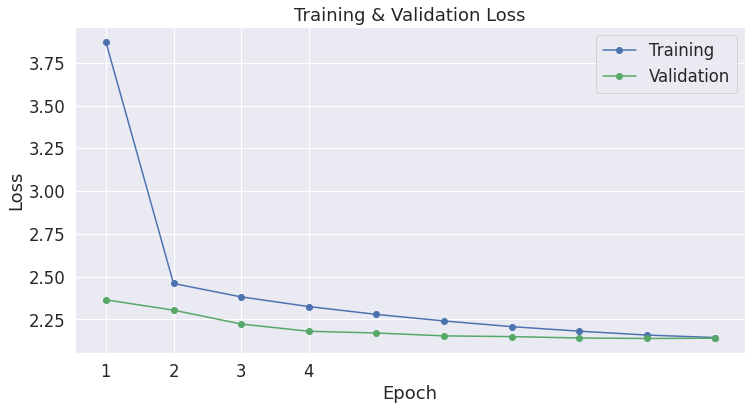

In [ ]:
import seaborn as sns
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=10, 
                                max_length = 100,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: aaron kaepernick told tmz fox sport ’ s fox fox sport host adam kelly he ’ s still playing football aaron kaepernick told tmz fox sport ’ s fox sport host adam kelly he ’ s still playing football jim kaepernick told tmz fox sport ’ s fox sport host adam kelly he ’ s still playing football kaepernick told tmz fox sport ’ s fox sport host adam kelly he ’


1: washington — — congressional intelligence committee released secret report today that former national security advisor former national intelligence director former national intelligence director john khan briefed senior administration official last month senior administration official told u intelligence director briefed senior administration official former national security advisor john khan briefed senior administration official former national security advisor john khan briefed senior administration official last month senior administration official briefed senior administration official for

In [ ]:
%%writefile meta.py
SUMMARY_STORY = """
<div class="story-box font-body">
<p>
Hello everyone 👋, I am <strong>Chef Transformer</strong>, 
the owner of this restaurant. I was made by a group of <a href="https://huggingface.co/flax-community/t5-recipe-generation#team-members">NLP Engineers</a> to train my two prodigy recipe creators: <strong>Chef Scheherazade</strong> and <strong>Chef Giovanni</strong>. 
Both of my students participated in my rigorous culinary program, <a href="https://huggingface.co/flax-community/t5-recipe-generation">T5 fine-tuning</a>, 
to learn how to prepare exquisite cuisines from a wide variety of ingredients. 
I've never been more proud of my students -- both can produce exceptional dishes but I regard Scheherazade as being <em>creative</em> while Giovanni is <em>meticulous</em>. 
If you give each of them the same ingredients, they'll usually come up with something different. <br /><br />
At the start of the program the chefs read cookbooks containing thousands of recipes of varying difficulties and from cultures all over the world. 
The NLP engineers helped guide the learning process so that the chefs could actually learn which ingredients work well together rather than just memorize recipes. 
I trained my chefs by asking them to generate a title, a list of ingredients (including amounts!), and a list of directions after giving them just a simple list of food items. 
</p>
<pre>[Inputs]
    {food items*: separated by comma}
     
[Targets]
    title: {TITLE} &lt;section>
    ingredients: {INGREDIENTS: separated by &lt;sep>} &lt;section>
    directions: {DIRECTIONS: separated by &lt;sep>}.
</pre>
<p>
  <em>In the cookbooks (a.k.a <a href="https://huggingface.co/datasets/recipe_nlg">dataset</a>), the food items were referred to as NER. </em>
</p>
<p>
In the span of a week, my chefs went from spitting out nonsense to creating masterpieces. 
Their learning rate was exceptionally high and each batch of recipes was better than the last. <br />
In their final exam, they achieved <a href="https://huggingface.co/flax-community/t5-recipe-generation#evaluation">high scores</a> 💯 in a 
standardized industry test and established this restaurant 🍲. Please tell your friends and family about us! 
We create each recipe with a smile on our faces 🤗 Everyone at the restaurant is grateful for the generous support of 
HuggingFace and Google for hosting Flax Community week. 
</p>
</div>
""".strip()